# <span style='font-family:"Times New Roman"'> <span styel=''>**GLIOMA ANALYSIS**

*Emile Cohen*
    
*June 2020*

**Goal**: In this notebook, we want to understand what makes Glioma an outlier for the patterns we saw, and what are the major subcohorts that drive the outlying signal.

---

In [15]:
%run -i '../../../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

## Interesting functions

In [140]:
from functools import reduce

def get_hotspots(df: pd.DataFrame, Sample_Type: str, group: list = None, group_type:str = None):
    data = df[df['Sample_Type'] == Sample_Type]
    
    if group and group_type:
        data = data[data[group_type].isin(group)]

    data_1 = get_groupby(data,'tp53_spot_1', 'count'); data_2 = get_groupby(data,'tp53_spot_2', 'count'); data_3 = get_groupby(data,'tp53_spot_3', 'count') ; data_4 = get_groupby(data,'tp53_spot_4', 'count') ; data_5 = get_groupby(data,'tp53_spot_5', 'count') 
    series_data = [data_1,data_2,data_3,data_4,data_5]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                                how='outer'), series_data).fillna(0)

    df_merged.columns = ['count_1', 'count_2', 'count_3', 'count_4', 'count_5']
    df_merged['total'] = df_merged.sum(axis=1)
    df_merged = df_merged.sort_values(by='total', ascending=False)

    df_merged = df_merged.drop('nan')
    
    return df_merged

def get_hotspot_frac(df: pd.DataFrame, group_type:str = None, group: list = None, nb = 10):
    if group_type and group:
        df = df[df[group_type].isin(group)]
    result = [['spot', '#', 'frac']]
    for spot in get_groupby(df, 'tp53_spot_1', 'count').sort_values(by='count', ascending=False).head(nb).index.tolist():
        result.append([spot,df[df['tp53_spot_1'] == spot].frac_genome_altered.shape[0], df[df['tp53_spot_1'] == spot].frac_genome_altered.median()])

    return pd.DataFrame(result)



def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)

    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font)
    
    groupby_ = get_groupby(df,group, 'count')
    groupby_ = groupby_.T
    for mut in mutation_list:
        if mut not in groupby_.columns:
            groupby_[mut] = 0
    groupby_ = groupby_.T
    
    labels = []
    for element in order:
        labels.append(element + '\n('+ str(groupby_.loc[element].values[0])+')')
    
    
    
    ax.set_xticklabels(labels)
    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax
# Let's give a look at medians and statistics

def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)

def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10):
    samples = master.Tumor_Id.tolist()
    maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)

def create_co_drivers_table(master: pd.DataFrame, group_type:str,  group_1: str, group_2: str):
    master_group_1 = master[master[group_type] == group_1]
    co_drivers_group_1 = get_major_codrivers(master=master_group_1,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_1['proportion_1'] = co_drivers_group_1.apply(lambda x: 100* round(x['count'] / co_drivers_group_1.sum().values[0], 4), axis=1)
    
    master_group_2 = master[master[group_type] == group_2]
    co_drivers_group_2 = get_major_codrivers(master=master_group_2,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_2['proportion_2'] = co_drivers_group_2.apply(lambda x: 100* round(x['count'] / co_drivers_group_2.sum().values[0], 4), axis=1)
    
    co_drivers_groups = pd.merge(co_drivers_group_1, co_drivers_group_2, on='Hugo_Symbol')
    co_drivers_groups['proportion_1'] = - co_drivers_groups['proportion_1']
    
    return co_drivers_groups

## Master Definition and Filtering

In [8]:
cancer='Glioma'

In [9]:
master_no_wgd = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')


master_no_wgd_cancer = master_no_wgd[master_no_wgd['Cancer_Type'] == cancer]
master_wgd_cancer = master_wgd[master_wgd['Cancer_Type'] == cancer]
maf_cohort_nowgd = pd.read_csv(data_path + 'impact-facets-tp53/processed/no_wgd/maf_cohort_nowgd.txt', sep='\t').drop('Unnamed: 0', axis=1)

# What makes Glioma an Outlier?

## WGD Proportion

Glioma is the cancer with the lowest WGD proportion, around 5%:
<img src="wgd_proportion.png" width=700 length=700>

## Cancer Panel - Non WGD Cohort

<img src="subgroup_proportion.png">

Glioma is highly enriched in Primary Samples, in *>1muts* subgroup and in composite mutation samples in general

## Genome Instability

<img src="gi_pancancer_frac_no_wgd.png">

Glioma is one of the three cancers that shows an outlying signal in Genome Instability Pattern: while almost all cancers have a correlation between tp53 bi allelic state, Glioma, Pancreatic Cancer an d Melanoma do not show this GI difference.

<img src="pancancer_gi_sub.png">

Glioma shows an outlying pattern:
* 0_HETLOSS is as high as >=1_LOSS
* '>=1_cnLOH' is the lowest subgroup, while it is a likely bi-allelic subgroup like >=1_LOSS

# WGD Part

## Subgroup Proportion
We have already seen that the WGD proportion of Glioma was really low. Here we see that the WGD cohort size is very small in comparison with the Non-WGD Cohort size for Glioma.

<img src="pre_prop.png" width=1000 length=600>
<img src="pre_legend.png" width=200 length=200>

<img src="mut_loh_prop.png" width=1000 length=600>
<img src="mut_loh_legend.png" width=200 length=200>

## Very High Genome Instability

In WGD cohort, Genome Instability median is above 70% for all cancer types.

<img src="pancancer_gi_wgd.png" width=1000 length=600>

# Non WGD Part - Cancer Investigation
In this section, our goal is to find subcohorts that lead the signals observed. Here are the different subcohort we will create:
* Hotspot Analysis: splitting on 273 / 248 / 175 / Missense / Truncated / In Frame
* CCF Analysis
* SNV/INDEL Analysis

## Hotspot Analysis
In this section, we cut our cohort to only keep samples with exactly one TP53 mutation, for simplicity.

<img src="mut_hotspot.png" width=500 length=500>

In [10]:
master_hotspot = master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] == 1]

In [13]:
get_hotspot_frac(df=master_hotspot,
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,273,29,0.171
2,248,23,0.17
3,nan,10,0.34
4,175,9,0.203
5,193,8,0.1855
6,282,8,0.211
7,245,7,0.256
8,238,7,0.214
9,342,6,0.334


### Entire Cohort

,count
tp53_vc_group_1,
missense,118
truncated,49
273,29
248,23
hotspot,19
in_frame,12
175,9


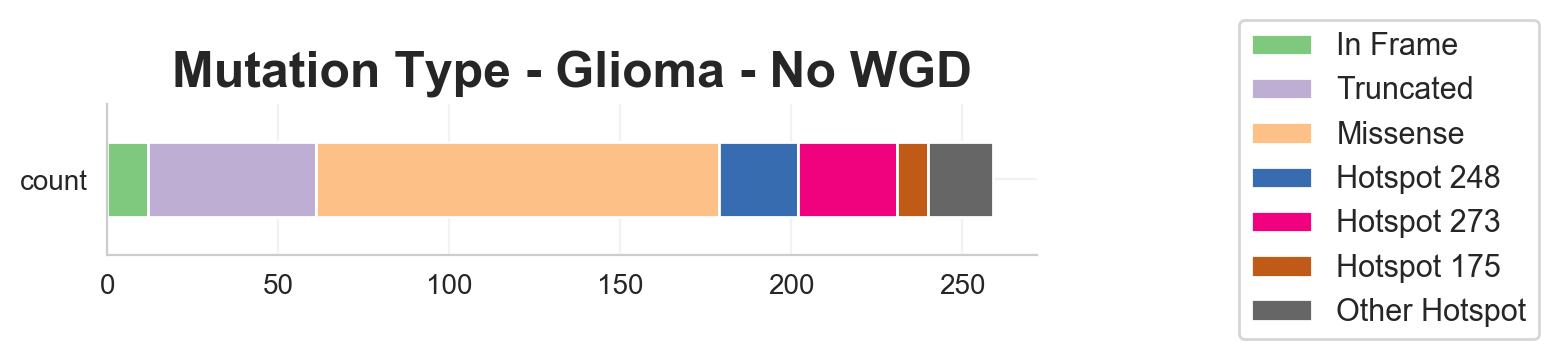

In [20]:
h = get_groupby(master_hotspot,'tp53_vc_group_1', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[mutation_list]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=11)
ax.set_title('Mutation Type - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

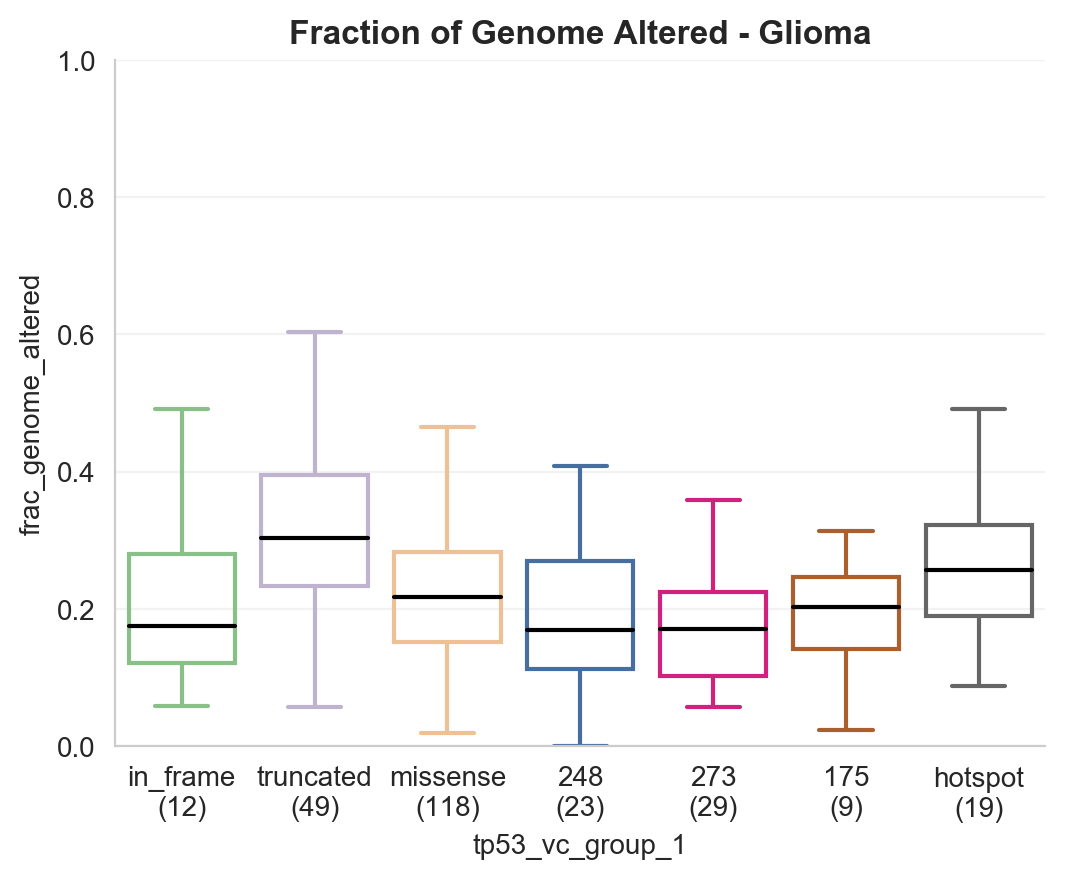

In [21]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='tp53_vc_group_1',
                  palette=mutation_palette,
                  order=mutation_list,
                  metrics='frac_genome_altered',
                  figsize=(6,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

* **Once more, it seems that 273 hotspot leads to lower GI**
* **In Glioma, Truncated mutations seem to be more unstable than Missense**

### TP53 Residual Subgroups

In [22]:
print('Number of Bi Allelic samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'no_tp53_res'].shape[0]))
print('')
print('Number of  TP53 Residual samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'tp53_res'].shape[0]))



Number of Bi Allelic samples (with 1 mut): 182

Number of  TP53 Residual samples (with 1 mut): 63


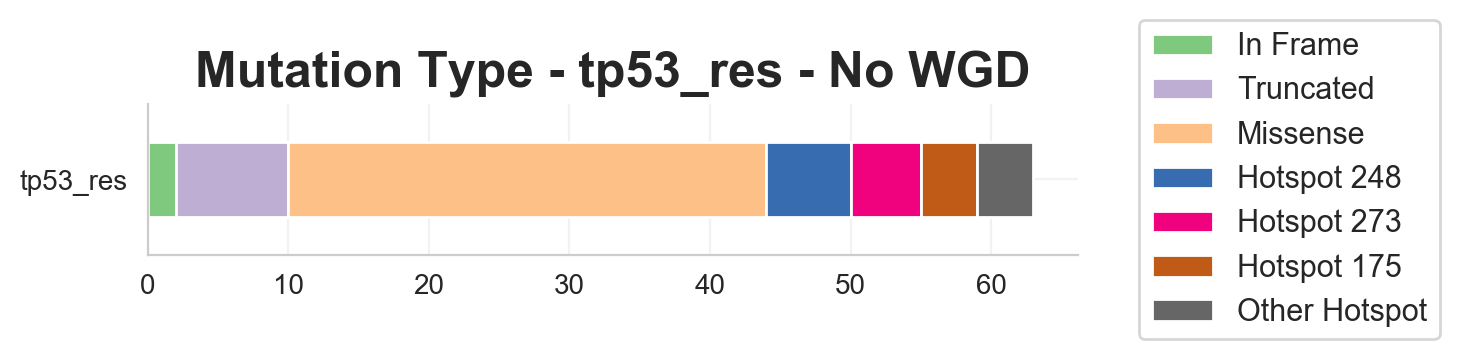

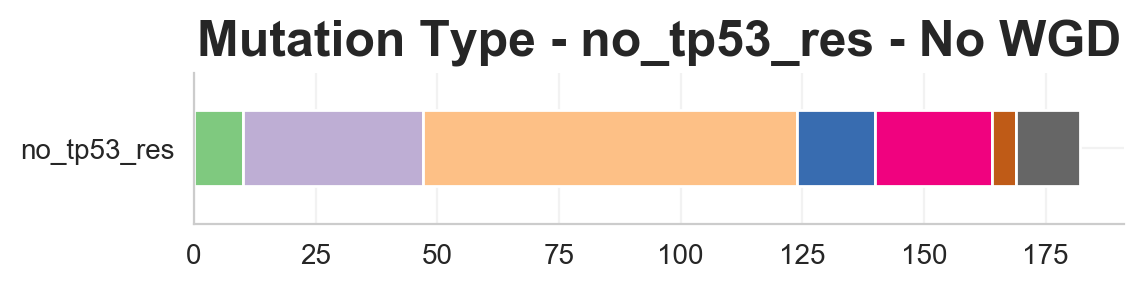

,tp53_res
tp53_vc_group_1,
missense,34
truncated,8
248,6
273,5
175,4
hotspot,4
in_frame,2
,no_tp53_res
tp53_vc_group_1,


In [23]:
total_df = []
for group in ['tp53_res', 'no_tp53_res']:
    h = get_groupby(master_hotspot[master_hotspot['tp53_res_group'] == group], 'tp53_vc_group_1', group).sort_values(by=group, ascending=False)
    total_df.append(h)
    
    h=h.T
    
    for mut in mutation_list:
        if mut not in h.columns:
            h[mut] = 0

    h = h[mutation_list]
    fig = plt.figure(figsize=(6,1))
    ax = plt.subplot()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
    if group == 'tp53_res':
        ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=11)
    else: ax.get_legend().remove()
    ax.set_title('Mutation Type - {} - No WGD'.format(group), weight='bold', fontsize=18)

    plt.show()

display_side_by_side(total_df[0],total_df[1])

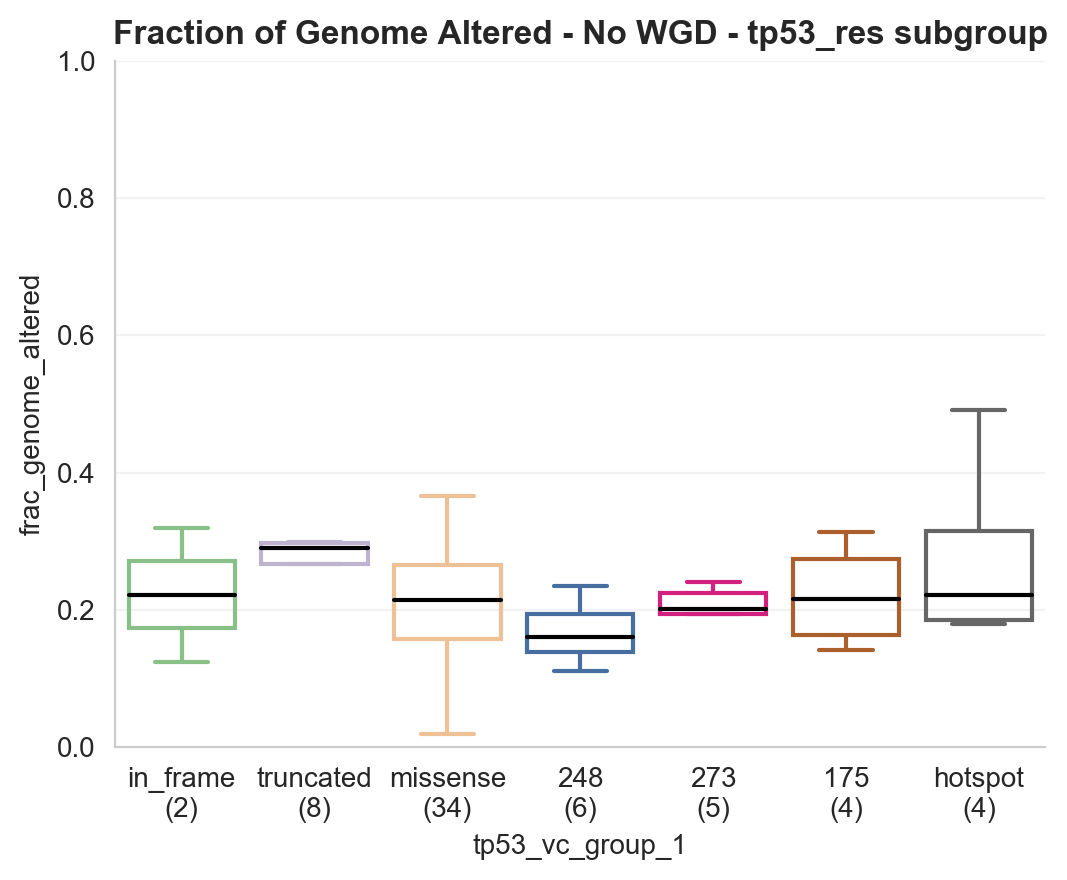

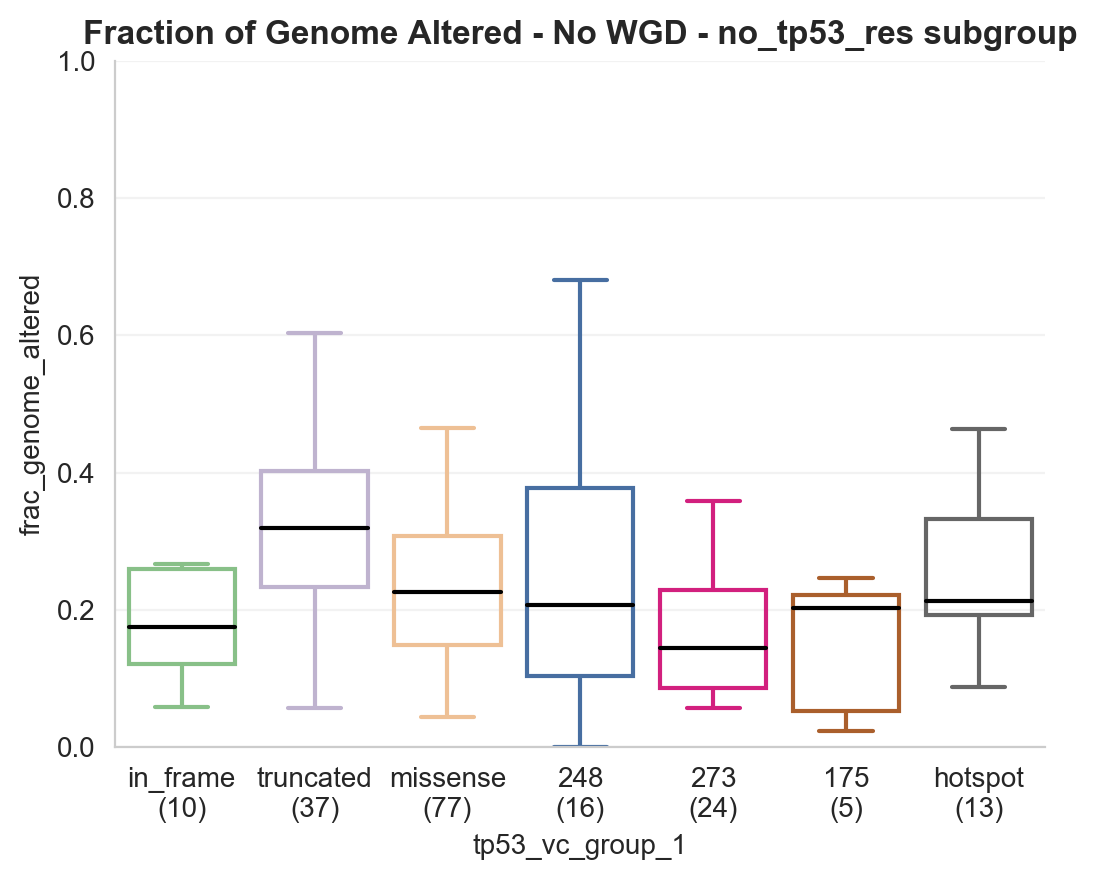

In [24]:
for group in ['tp53_res', 'no_tp53_res']:
    master_wt = master_hotspot[master_hotspot['tp53_res_group'] == group]

    fig, ax = boxplot_sampletype(df=master_wt,
                      group='tp53_vc_group_1',
                      palette=mutation_palette,
                      order=mutation_list,
                      metrics='frac_genome_altered',
                      figsize=(6,10),
                      title='Fraction of Genome Altered - No WGD - {} subgroup'.format(group),
                      xlim=[0,1])
    plt.show()

## SNV / INDEL Analysis
In this section we compare SNV and INDEL mutations. As in the previous section, we cut the cohort to keep only samples with exactly 1 tp53 mutation.

###  # of Drivers / SNV Drivers / INDEL Drivers 

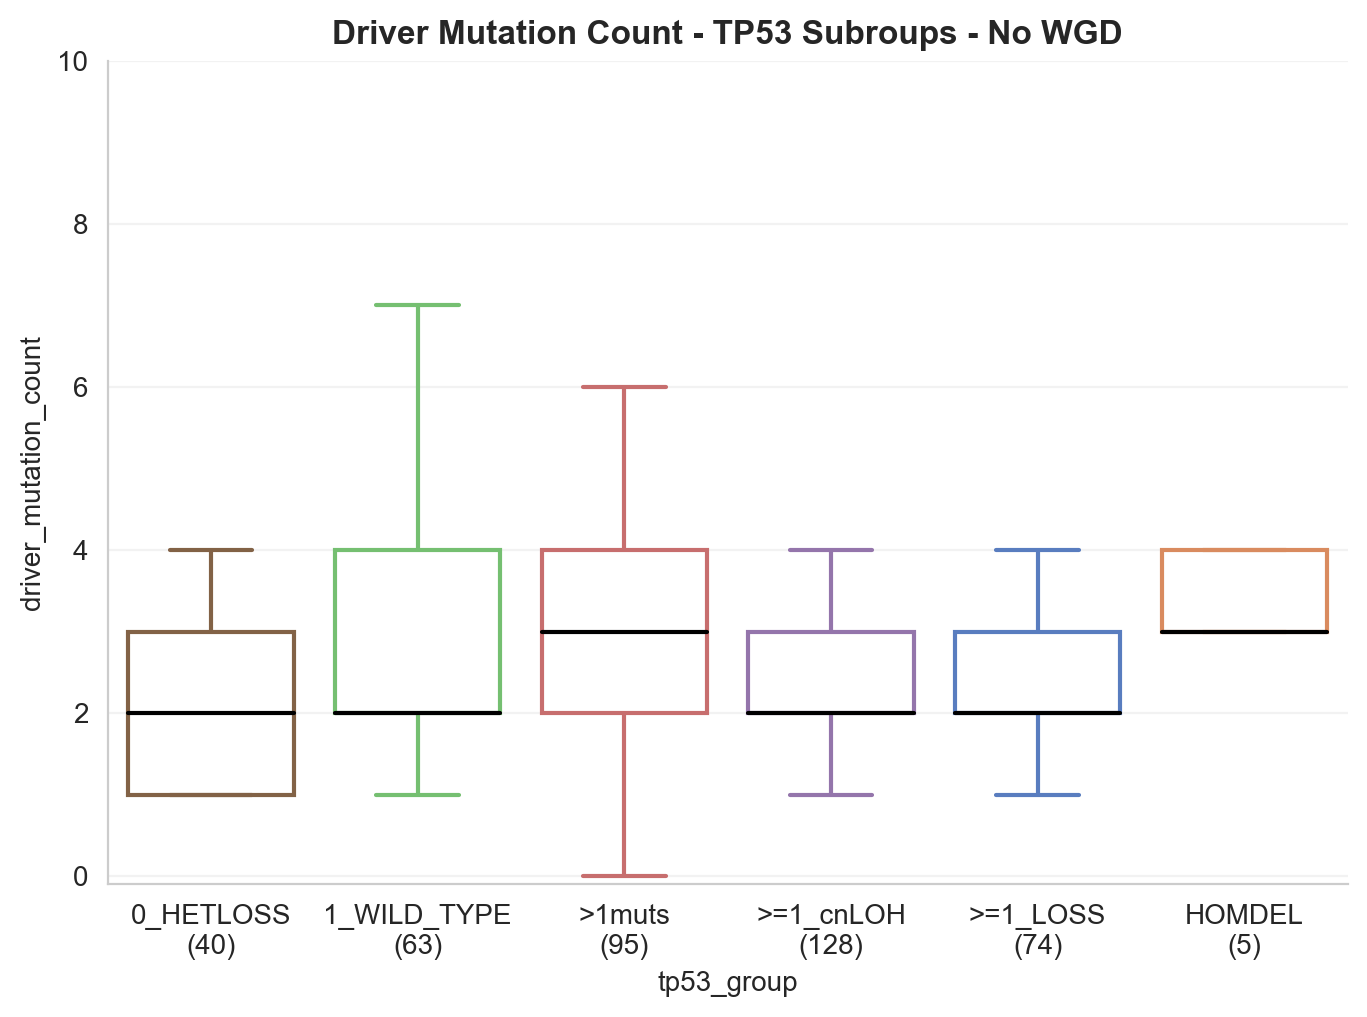

,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,63,2
2,0_HETLOSS,40,2
3,,Statistics,p-value
4,,1.69166,0.0907104
,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,63,2
2,>=1_LOSS,74,2
3,,Statistics,p-value


In [25]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,10])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

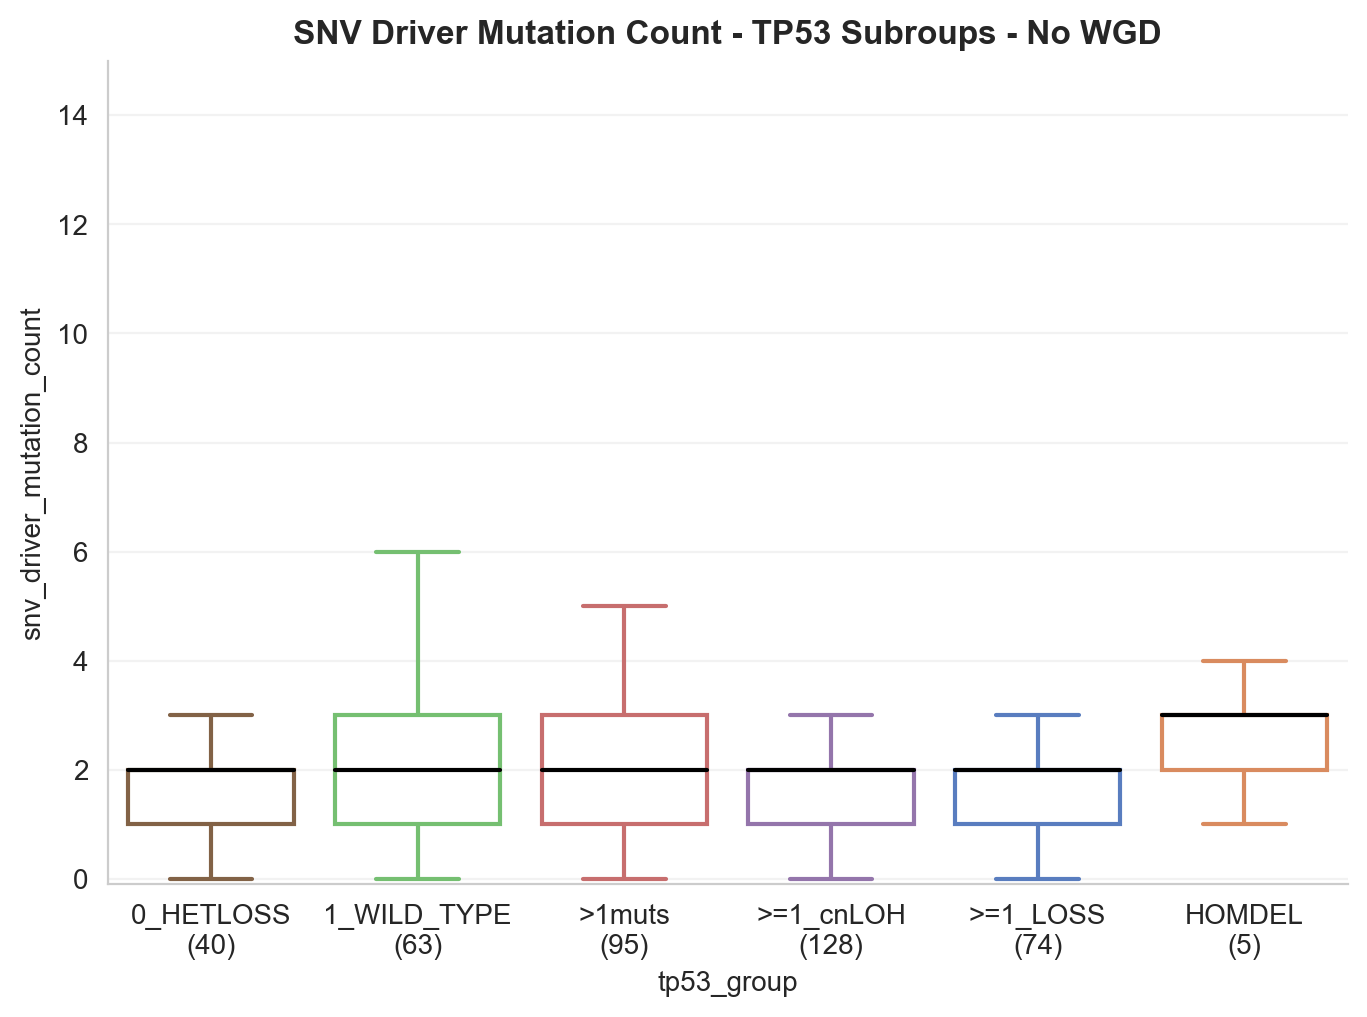

,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,63,2
2,0_HETLOSS,40,2
3,,Statistics,p-value
4,,2.13826,0.0324955
,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,63,2
2,>=1_LOSS,74,2
3,,Statistics,p-value


In [26]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='snv_driver_mutation_count',
                  figsize=(8,12),
                  title='SNV Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,15])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

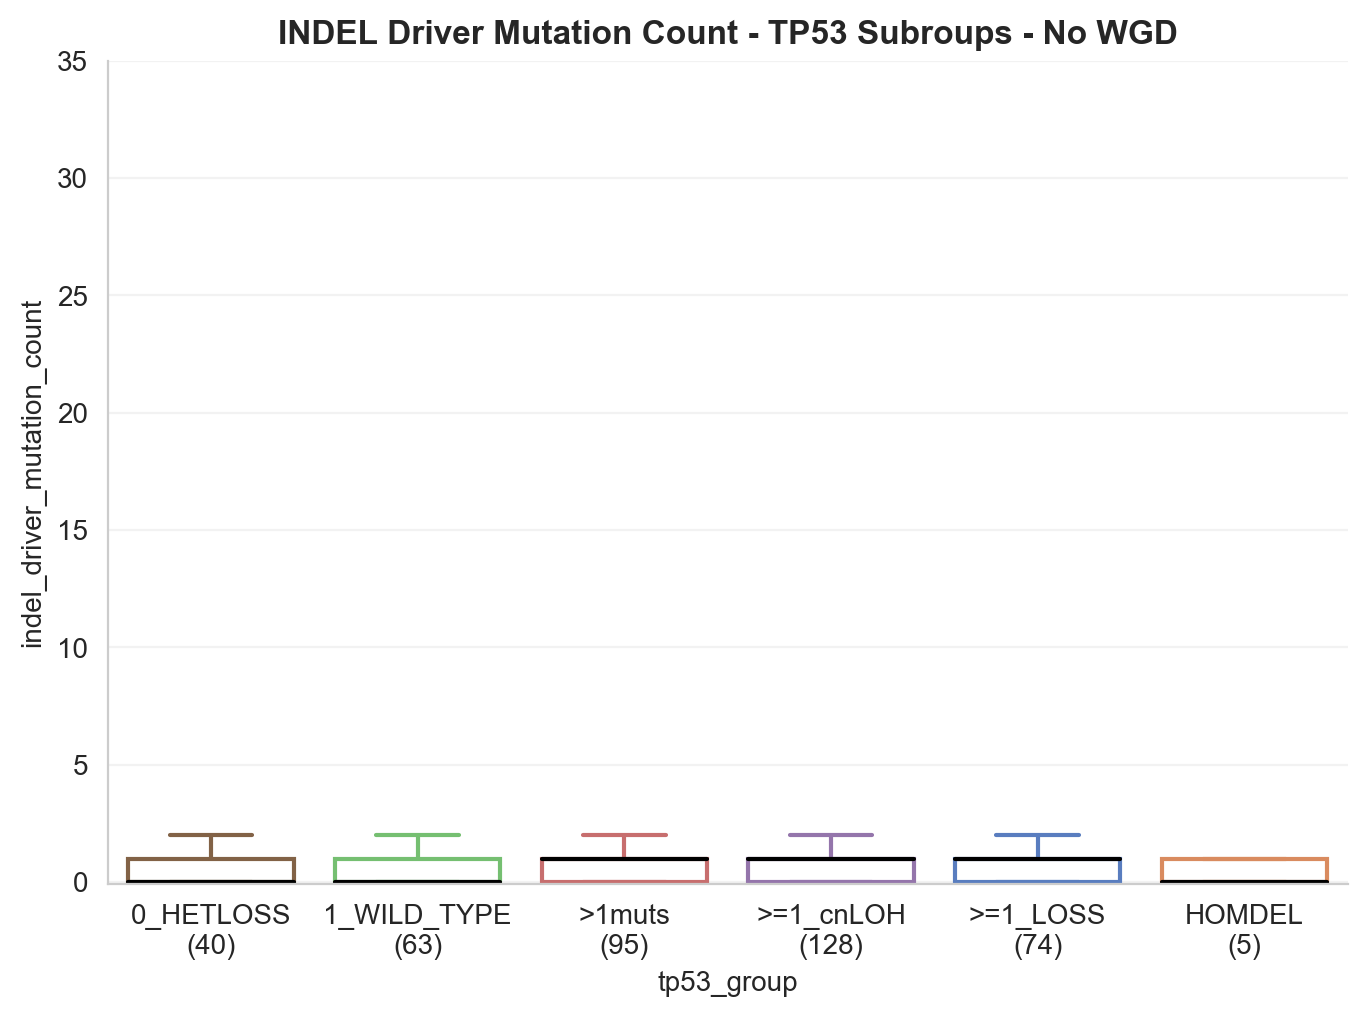

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,63,0
2,0_HETLOSS,40,0
3,,Statistics,p-value
4,,-0.17255,0.863006
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,63,0
2,>=1_LOSS,74,1
3,,Statistics,p-value


In [27]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,35])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

Here, one major information:
* In Glioma, there are very few numbers of Co-Drivers, INDEL Co-Drivers nor SNV Co-Drivers.
    * Maybe TP53 mutations in Glioma are very pervasvie and do not need more drivers to expand

### Genome Instability 
The idea here is to see if we have differences in Fraction of Genome Altered if we cut our Cancer cohort on the number of drivers per sample. 

Do we have more instability with more INDEL Driver Mutations within the same subgroup?

#### 1_WILD_TYPE Subgroup

In [28]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']

thr=1

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_wt['co_driver_group'] = master_no_wgd_cancer_wt.apply(get_driver_groups, axis=1)

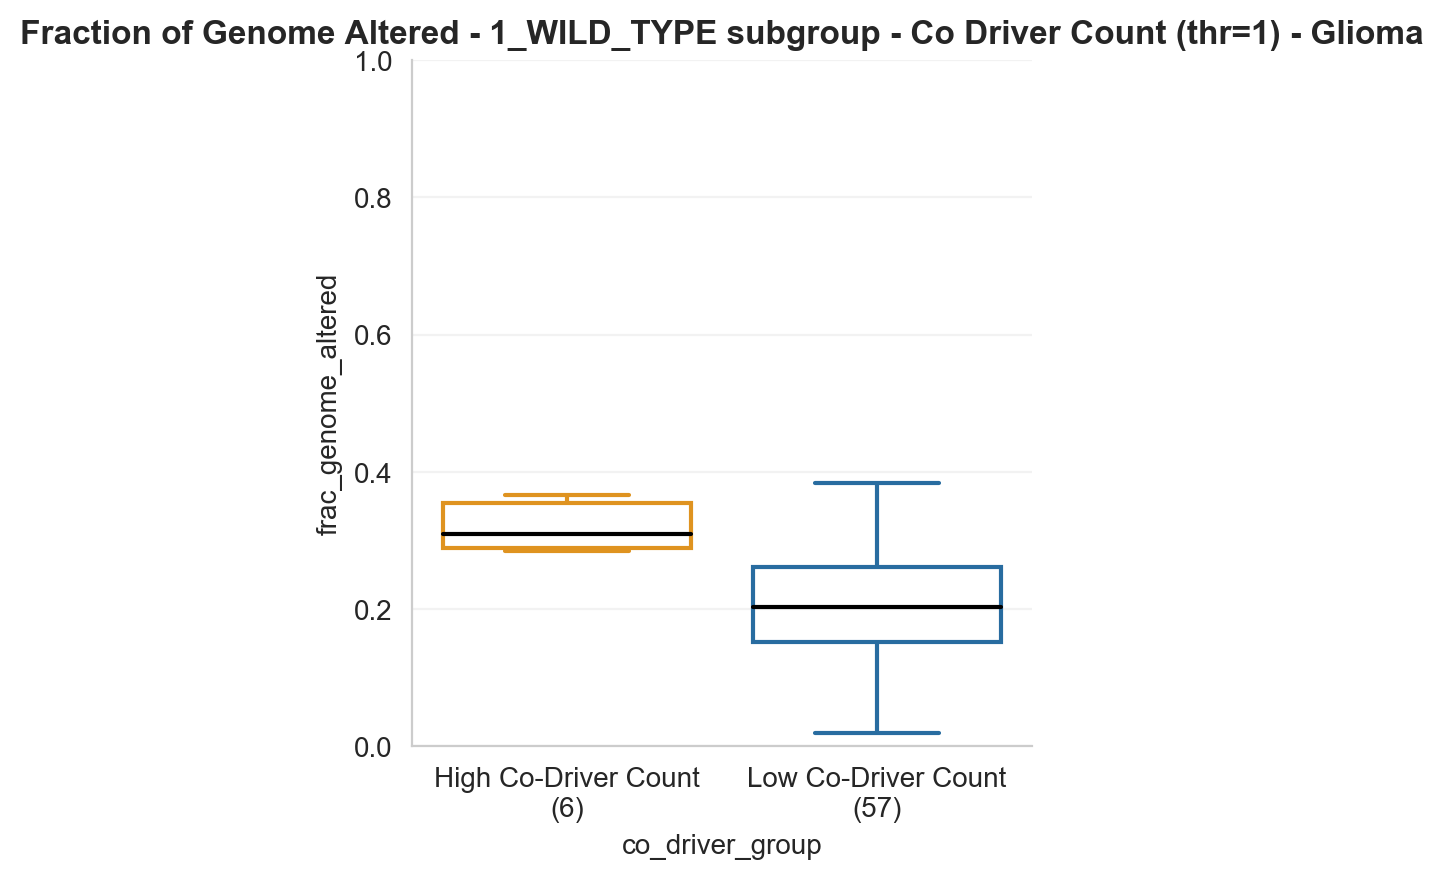

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,6,0.3095
2,Low Co-Driver Count,57,0.203
3,,Statistics,p-value
4,,2.59903,0.00934888


In [29]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

#### 0_HETLOSS

In [30]:
master_no_wgd_cancer_het = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '0_HETLOSS']

thr=1

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_het['co_driver_group'] = master_no_wgd_cancer_het.apply(get_driver_groups, axis=1)

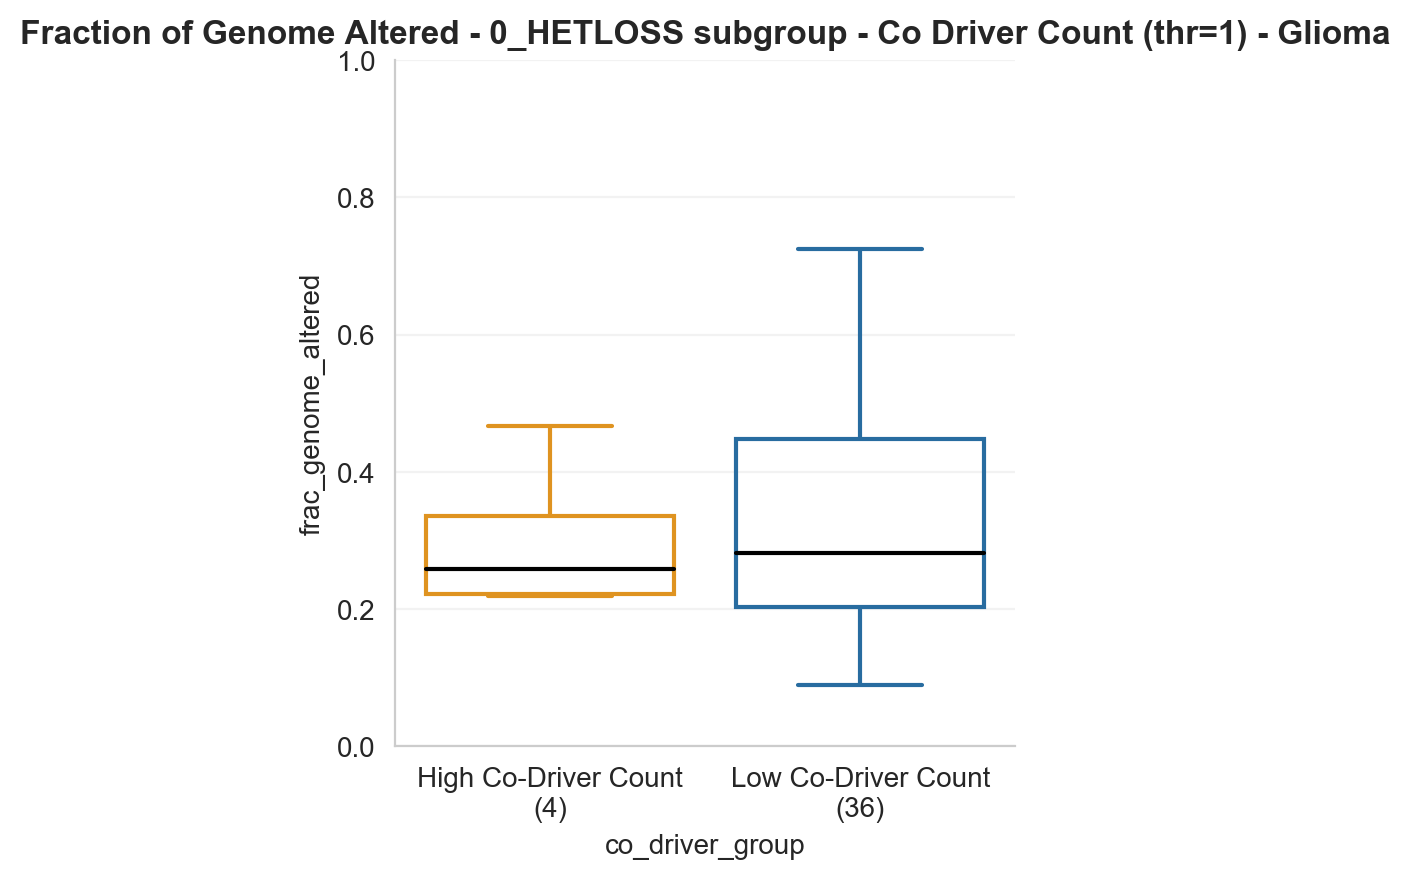

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,4,0.258
2,Low Co-Driver Count,36,0.2815
3,,Statistics,p-value
4,,0.13525,0.892414


In [31]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_het,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 0_HETLOSS subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_het,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

## Co Driver Analysis

In [150]:
codrivers_glioma = get_major_codrivers(master=master_no_wgd_cancer,
                    maf=maf_cohort_nowgd,
                    head=15)

codrivers_glioma_tp53 = get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] >= 1],
                    maf=maf_cohort_nowgd,
                    head=15)

In [156]:
co_drivers = pd.merge(codrivers_glioma, codrivers_glioma_tp53, on='Hugo_Symbol')
co_drivers.columns = ['cancer', 'cancer_tp53']

In [163]:
co_drivers['ratio'] = co_drivers.apply(lambda x: 100*round(x.cancer_tp53/x.cancer, 4) , axis=1)
co_drivers = co_drivers.sort_values(by='ratio', ascending=False)

In [164]:
co_drivers

,cancer,cancer_tp53,ratio
Hugo_Symbol,,,
ATRX,144,126,87.50
RB1,85,58,68.24
IDH1,285,152,53.33
ARID1A,35,14,40.00
PIK3R1,110,33,30.00
PTEN,302,90,29.80
PIK3CA,134,37,27.61
NOTCH1,42,11,26.19
NF1,203,52,25.62


Text(0.5, 1.0, 'Co-Drivers Enrichment in TP53 State')

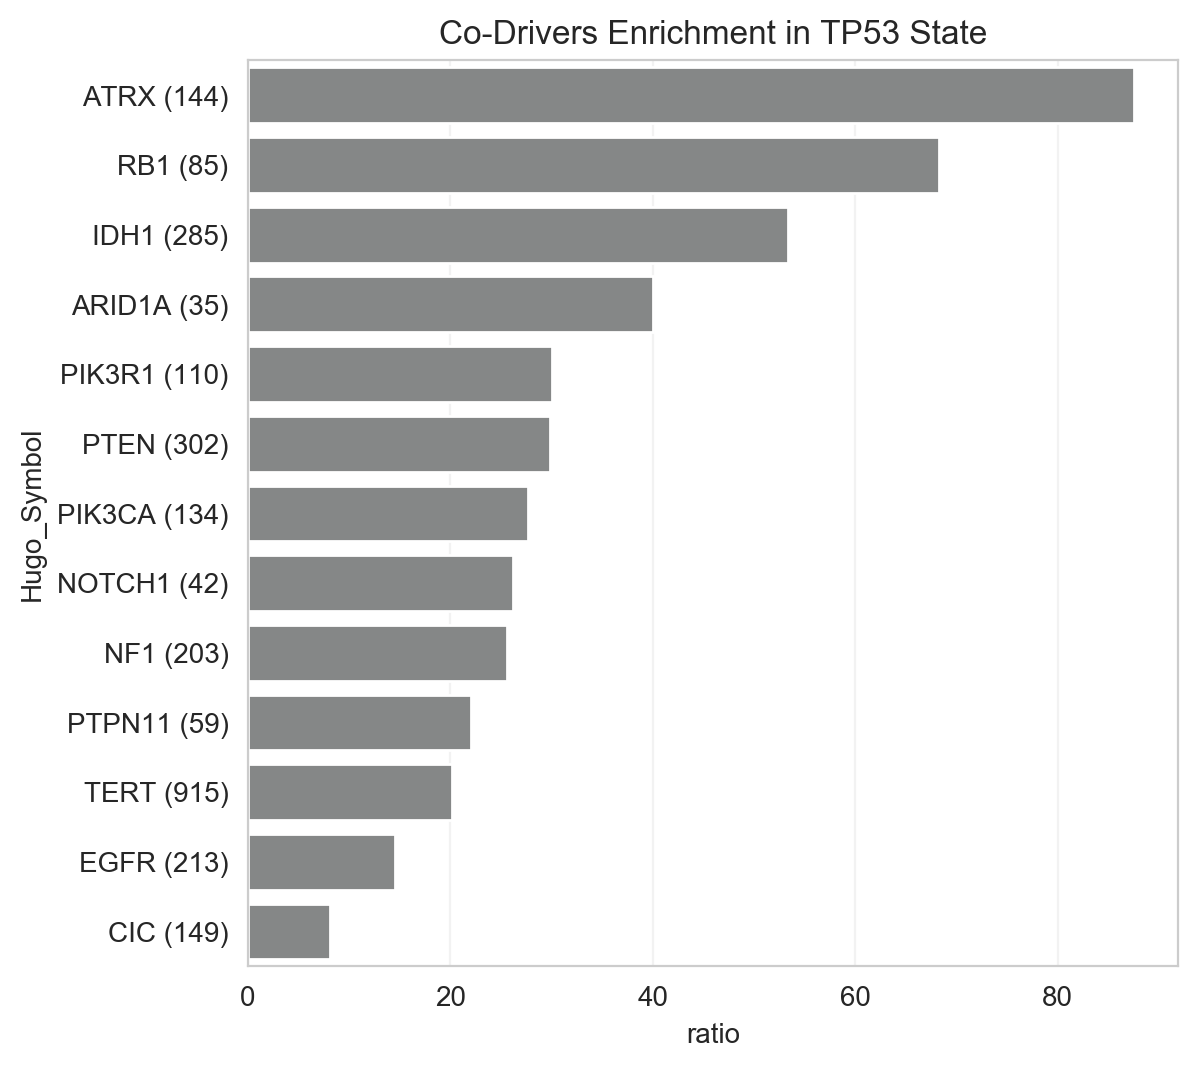

In [166]:
labels = []
for element in co_drivers.index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers.loc[element]['cancer']))+')')

ax = sns.barplot(y=co_drivers.index, x='ratio',data=co_drivers[['ratio']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Enrichment in TP53 State')

In [321]:
codrivers_glioma

,count
Hugo_Symbol,
TERT,915
PTEN,302
IDH1,285
EGFR,213
NF1,203
CIC,149
ATRX,144
PIK3CA,134
PIK3R1,110


Text(0.5, 1.0, 'Co-Drivers Frequency in Glioma')

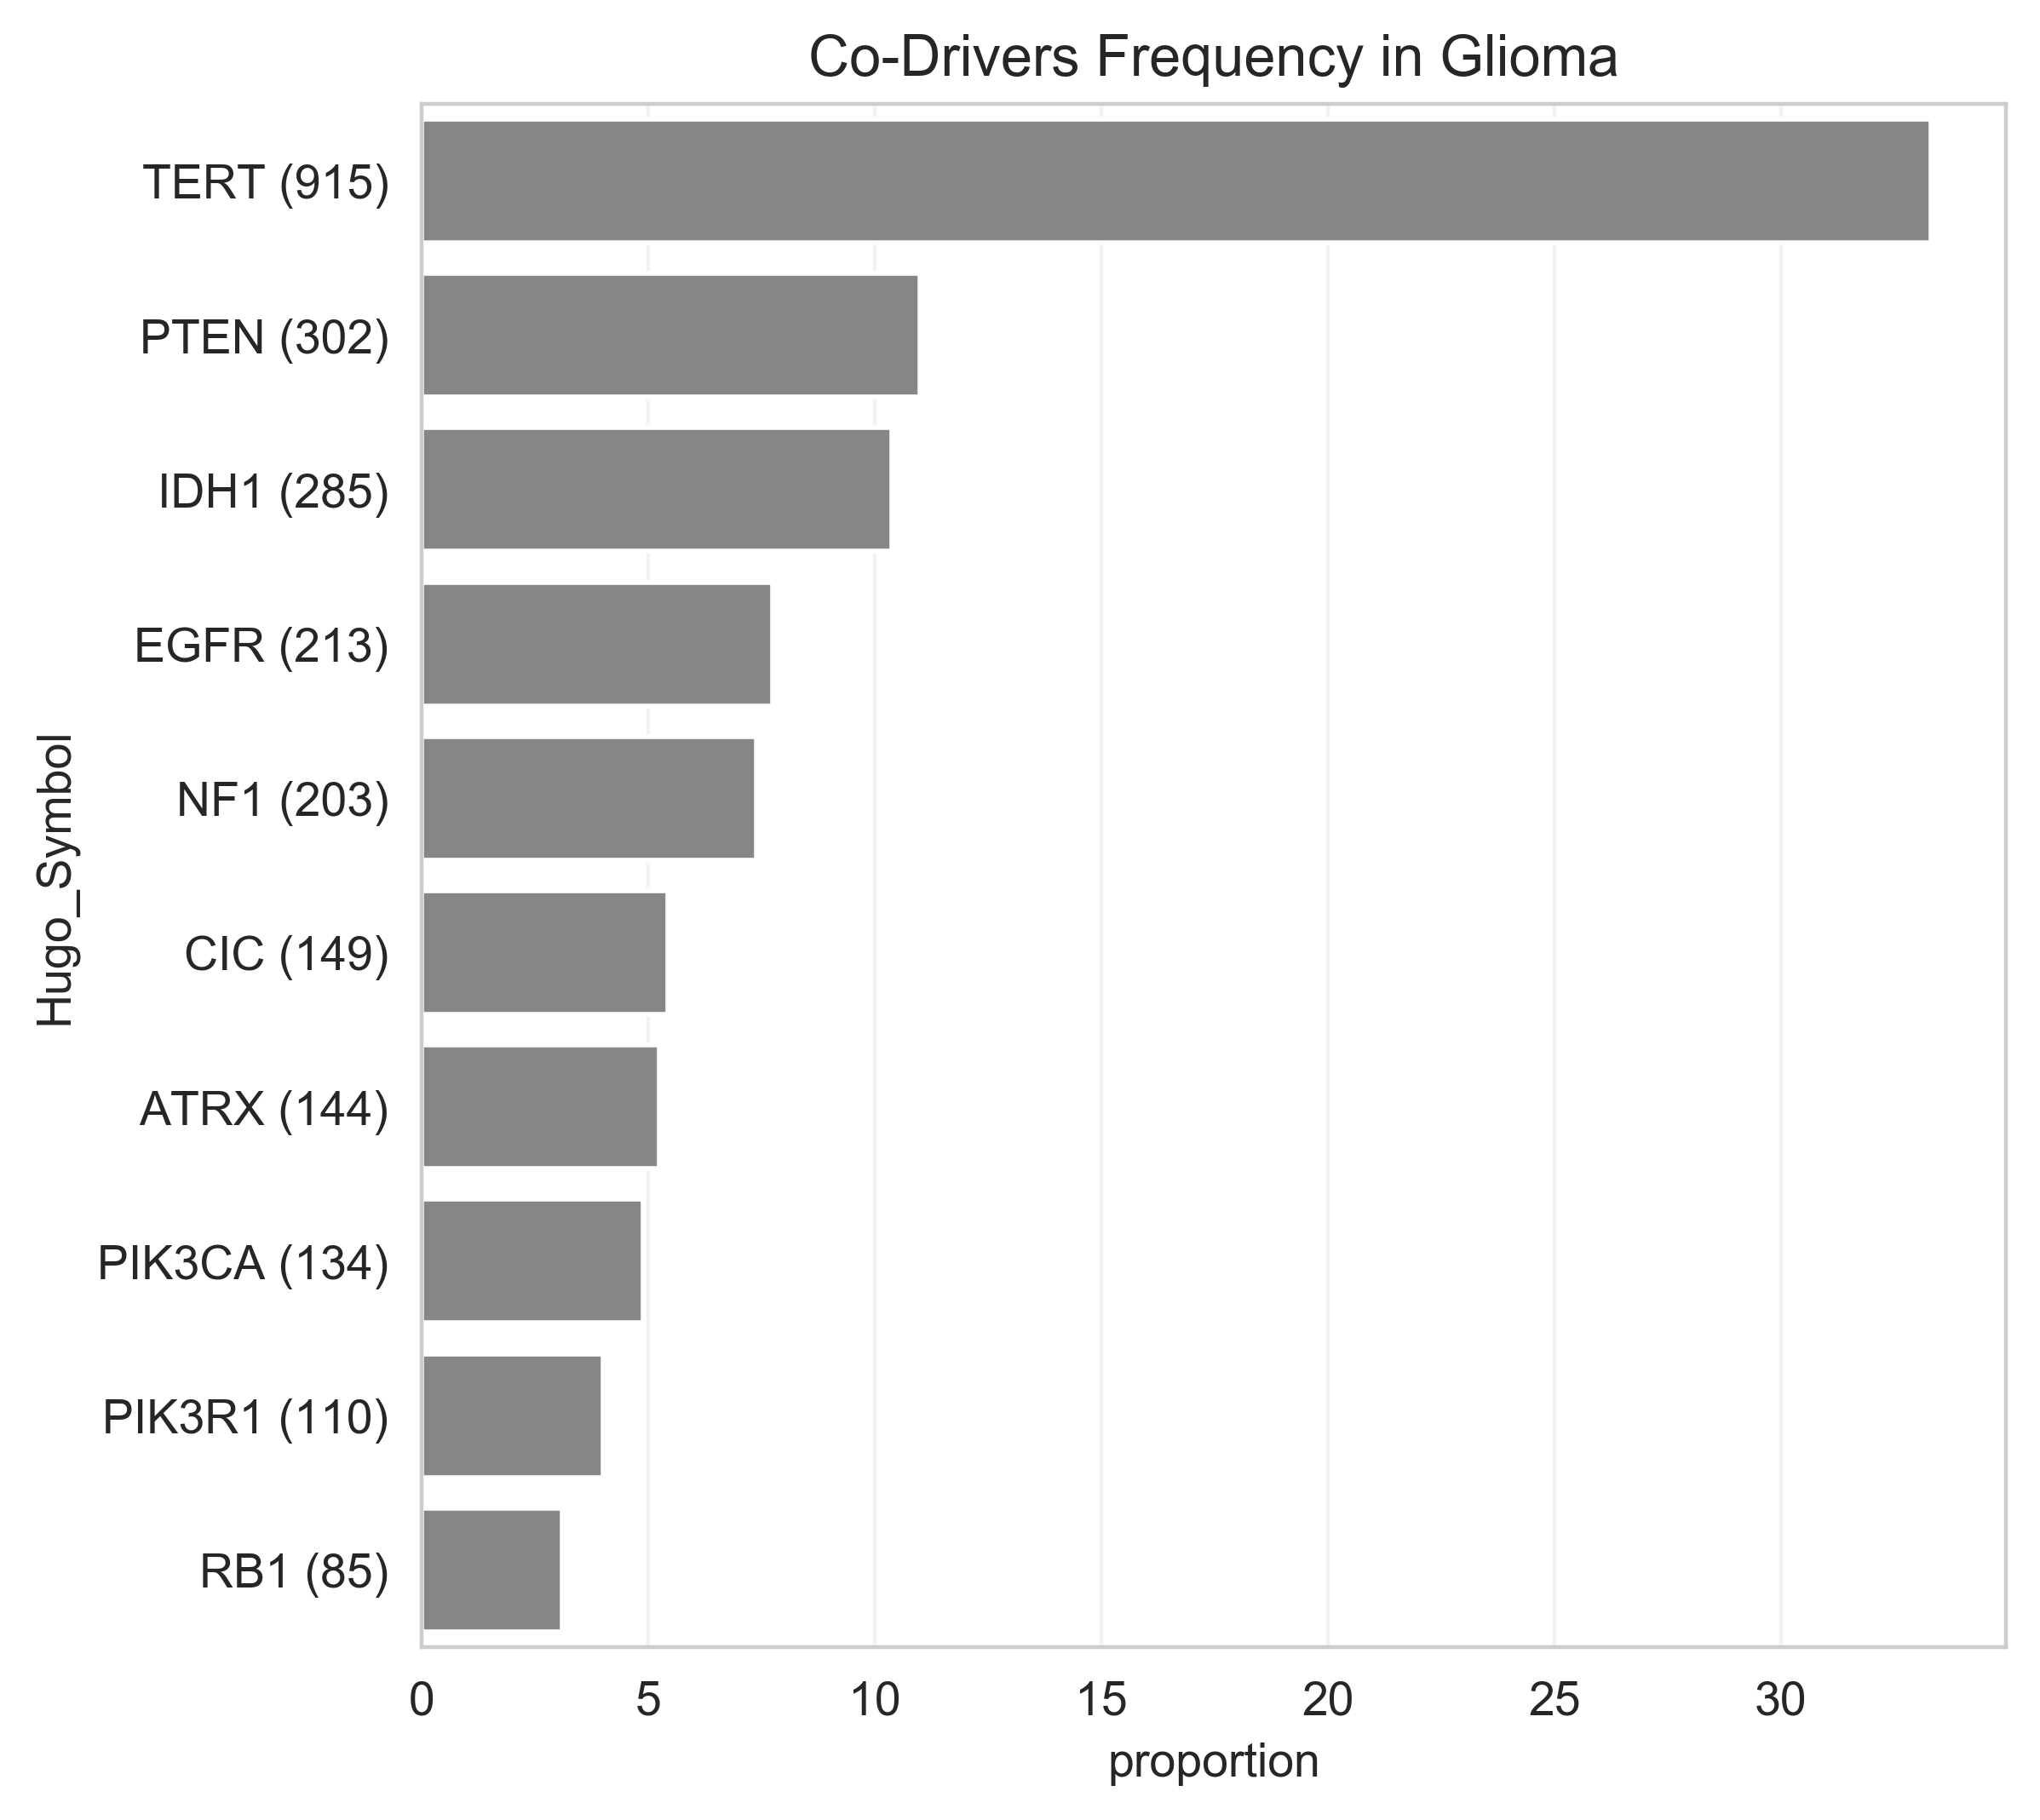

In [323]:
labels = []
codrivers_glioma = get_major_codrivers(master=master_no_wgd_cancer,
                    maf=maf_cohort_nowgd,
                    head=15)

codrivers_glioma['proportion'] = codrivers_glioma.apply(lambda x: 100* round(x['count'] / codrivers_glioma.sum().values[0], 4), axis=1)

for element in codrivers_glioma.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(codrivers_glioma.loc[element]['count']))+')')

ax = sns.barplot(y=codrivers_glioma.head(10).index, x='proportion',data=codrivers_glioma.head(10)[['proportion']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Frequency in {}'.format(cancer))

### Co-Drivers per subgroup

In [324]:
co_drivers_cnloh_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>=1_cnLOH',
                                                group_2='>=1_LOSS')
co_drivers_cnloh_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
IDH1,80,-23.46,4,2.20
ATRX,68,-19.94,6,3.30
TERT,37,-10.85,48,26.37
PTEN,18,-5.28,29,15.93
RB1,16,-4.69,25,13.74
PIK3CA,13,-3.81,2,1.10
NF1,9,-2.64,13,7.14
PIK3R1,9,-2.64,8,4.40
H3F3A,6,-1.76,4,2.20


Text(0.5, 1.0, 'Co-Drivers Frequency in >=1_LOSS - Glioma')

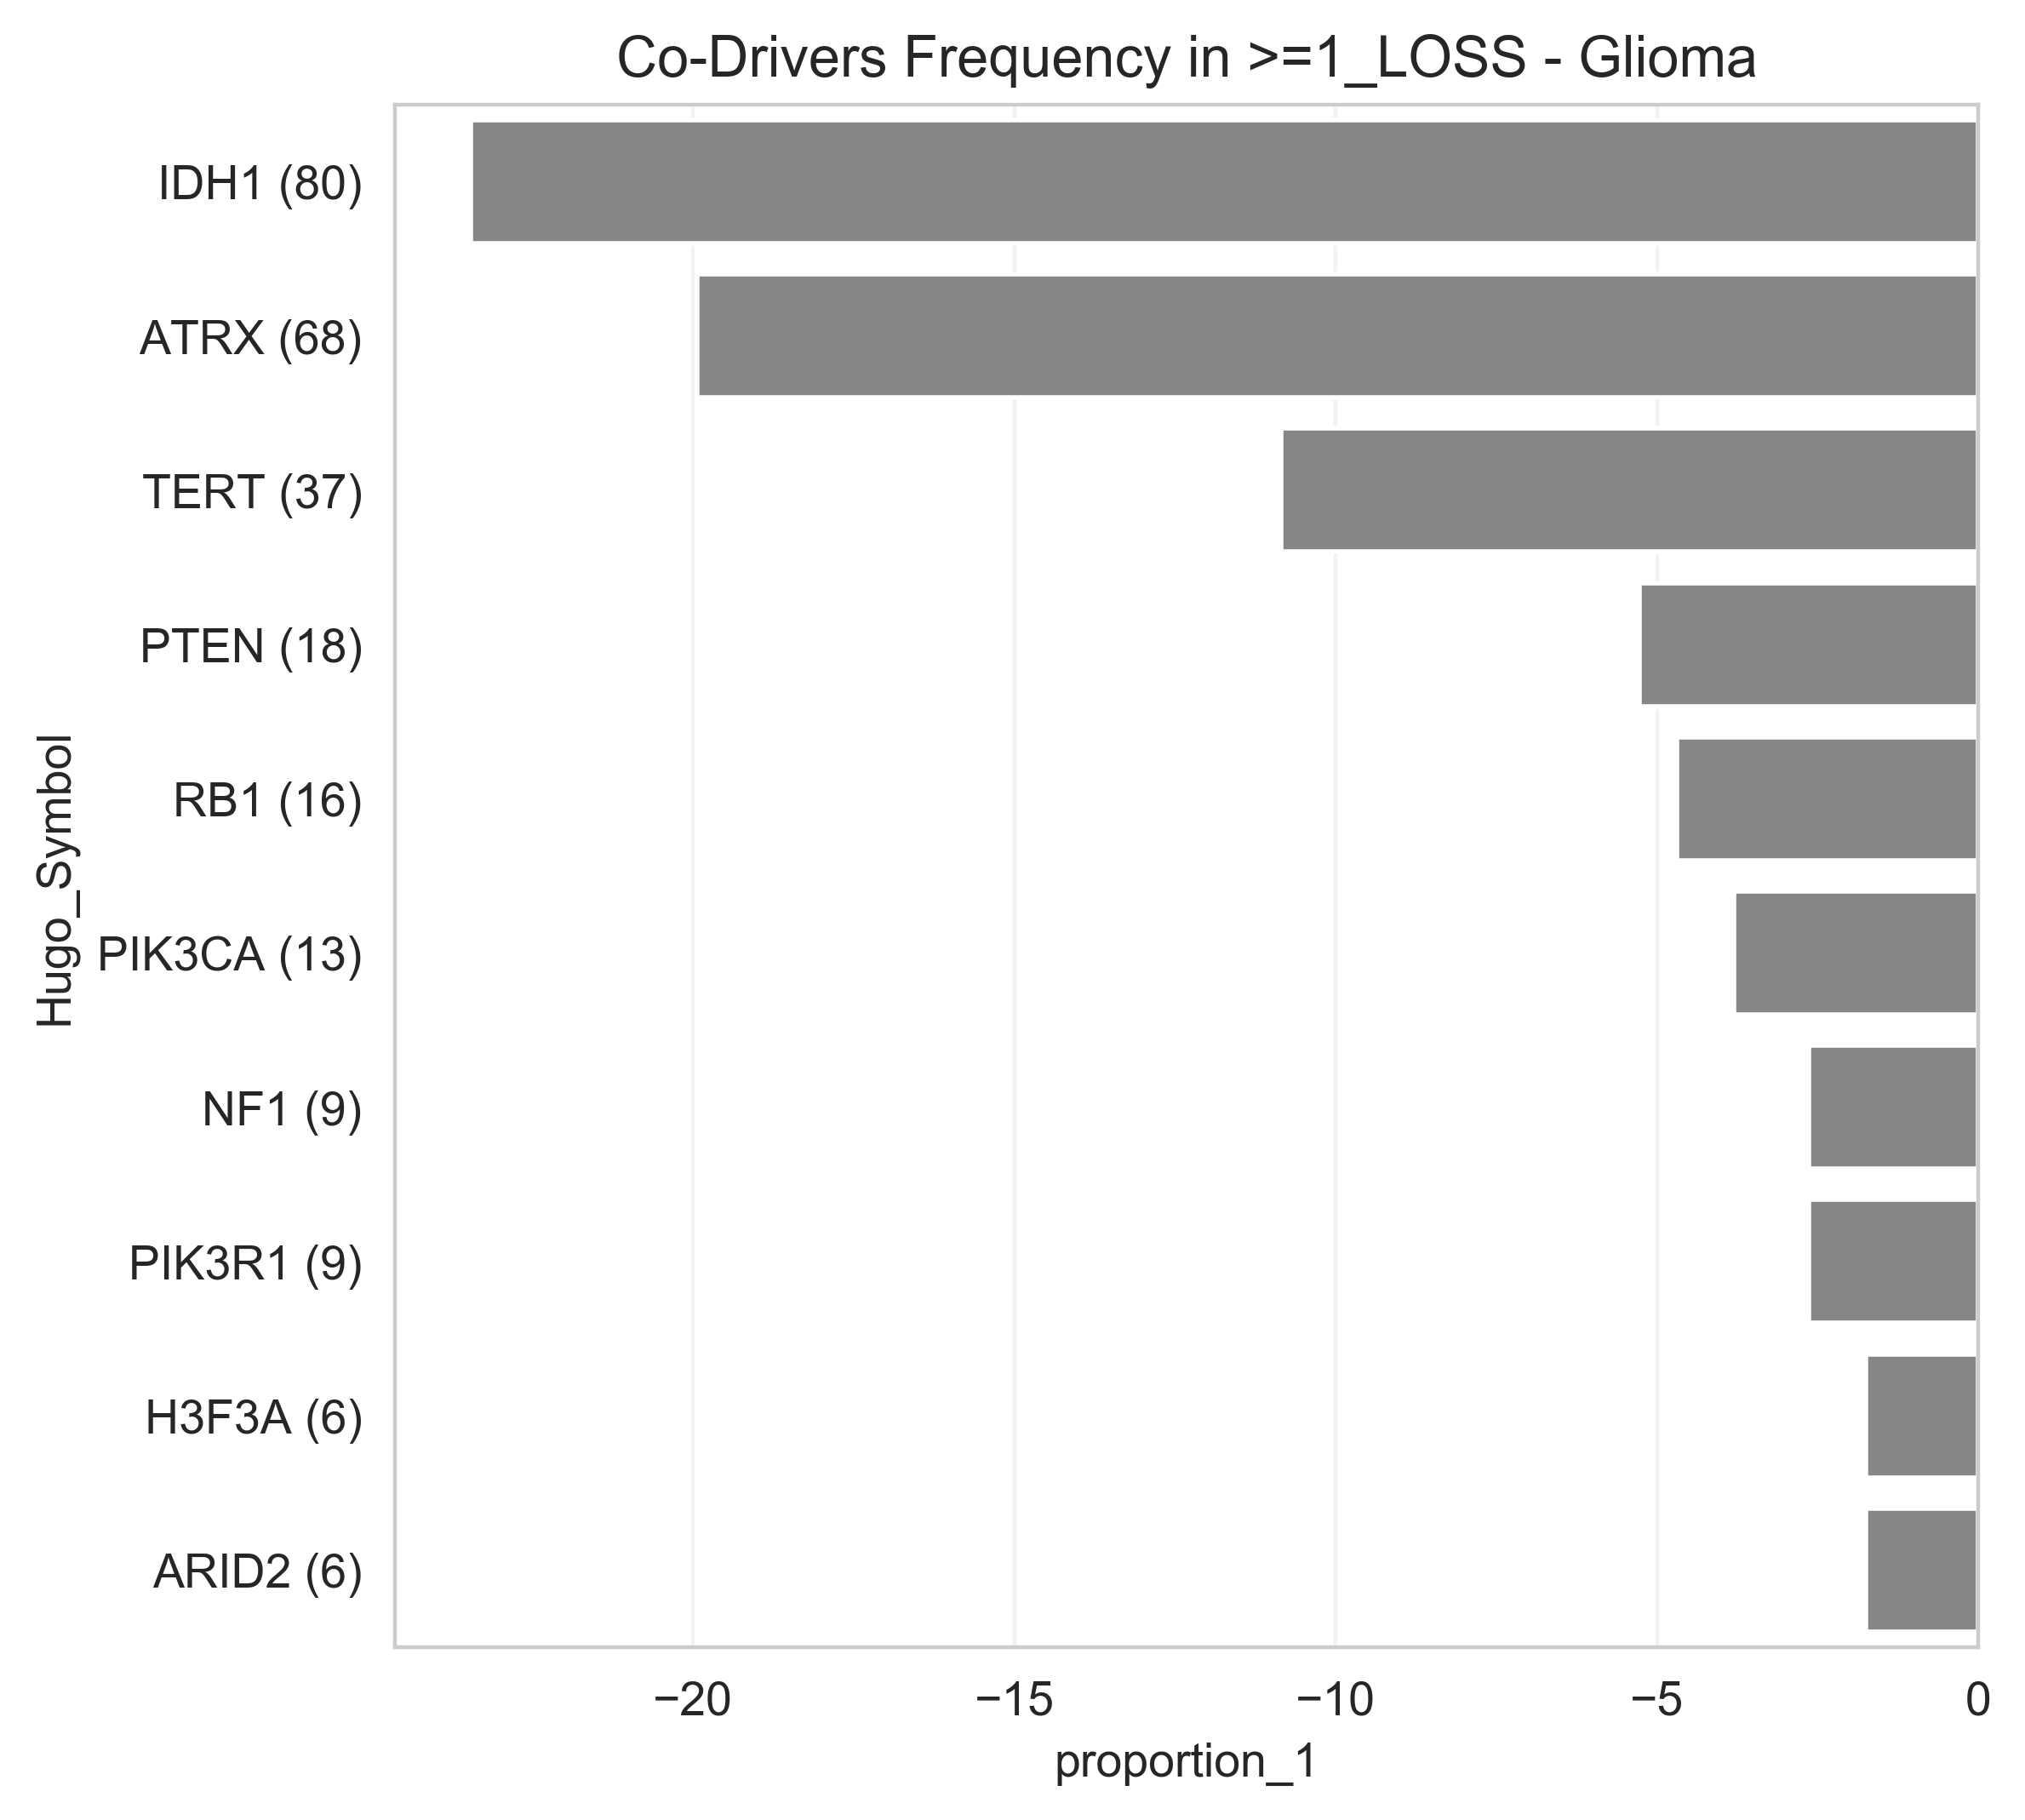

In [293]:
labels = []
for element in co_drivers_cnloh_loss.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers_cnloh_loss.loc[element]['count_x']))+')')

ax = sns.barplot(y=co_drivers_cnloh_loss.head(10).index, x='proportion_1',data=co_drivers_cnloh_loss.head(10)[['proportion_1']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Frequency in {} - {}'.format(subgroup, cancer))

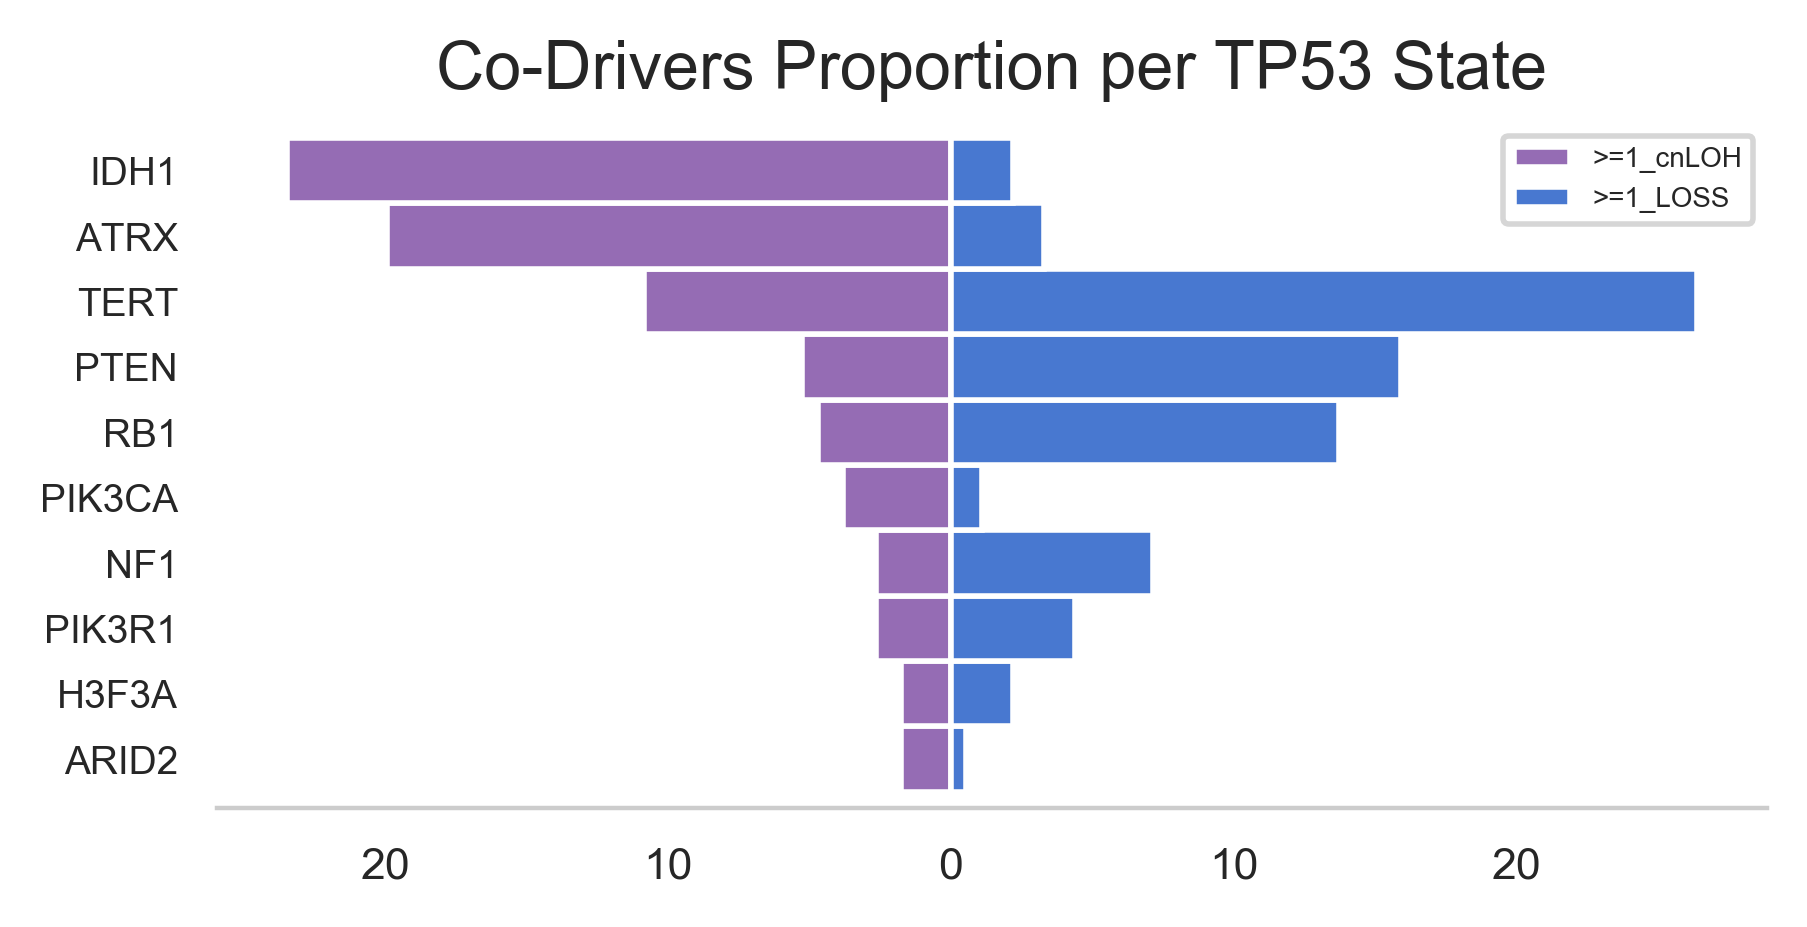

In [290]:
fig=plt.figure(figsize=(5,5))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_cnloh_loss[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[4],mc[0]])
ax.legend(['>=1_cnLOH', '>=1_LOSS'], fontsize=5)
ax.set_title('Co-Drivers Proportion per TP53 State')

plt.yticks(fontsize=7)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [30, 20, 10, 0, 10, 20, 30] 
ax.set_xticklabels(a, fontsize=8)
plt.grid(b=None)

plt.show()

Here we see twop different strong signals:
* In >=1_cnLOH, enrichment in **IDH1** and **ATRX** and depletion in **TERT**
* In >=1_LOSS, enrichment in **TERT**, but alos in **PTEN** and **RB1**

---

In [325]:
co_drivers_losses = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='0_HETLOSS',
                                                group_2='>=1_LOSS')
co_drivers_losses

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
TERT,26,-27.37,48,26.37
PTEN,11,-11.58,29,15.93
NF1,8,-8.42,13,7.14
RB1,6,-6.32,25,13.74
PIK3CA,6,-6.32,2,1.10
EGFR,4,-4.21,2,1.10
IDH1,3,-3.16,4,2.20
STAG2,2,-2.11,3,1.65
PTPN11,2,-2.11,1,0.55


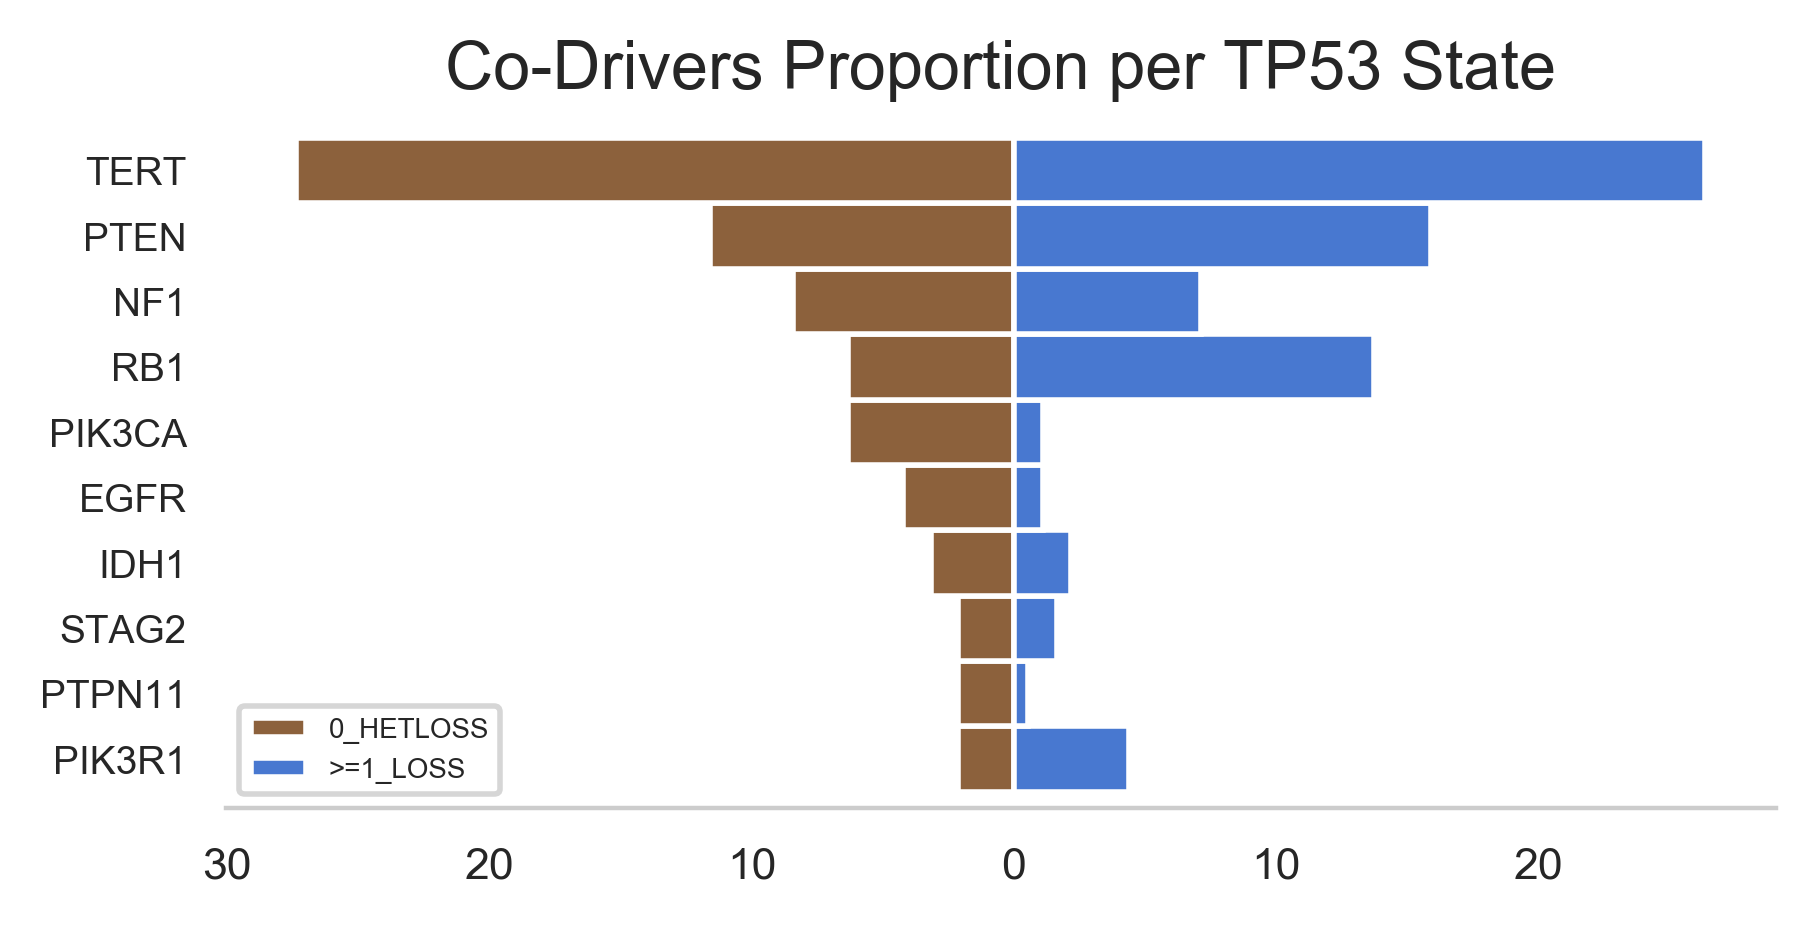

In [330]:
fig=plt.figure(figsize=(5,5))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_losses[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[5],mc[0]])
ax.legend(['0_HETLOSS', '>=1_LOSS'], fontsize=5)
ax.set_title('Co-Drivers Proportion per TP53 State')

plt.yticks(fontsize=7)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [40, 30, 20, 10, 0, 10, 20, 30]
ax.set_xticklabels(a, fontsize=8)
plt.grid(b=None)

plt.show()

* Same enrichment in **TERT** and **PTEN**
---

In [331]:
co_drivers_mult_cnloh = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>1muts',
                                                group_2='>=1_cnLOH')
co_drivers_mult_cnloh

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
IDH1,51,-13.53,80,23.46
ATRX,44,-11.67,68,19.94
TERT,39,-10.34,37,10.85
PTEN,20,-5.31,18,5.28
NF1,20,-5.31,9,2.64
RB1,12,-3.18,16,4.69
PIK3CA,10,-2.65,13,3.81
PIK3R1,9,-2.39,9,2.64
EGFR,8,-2.12,5,1.47


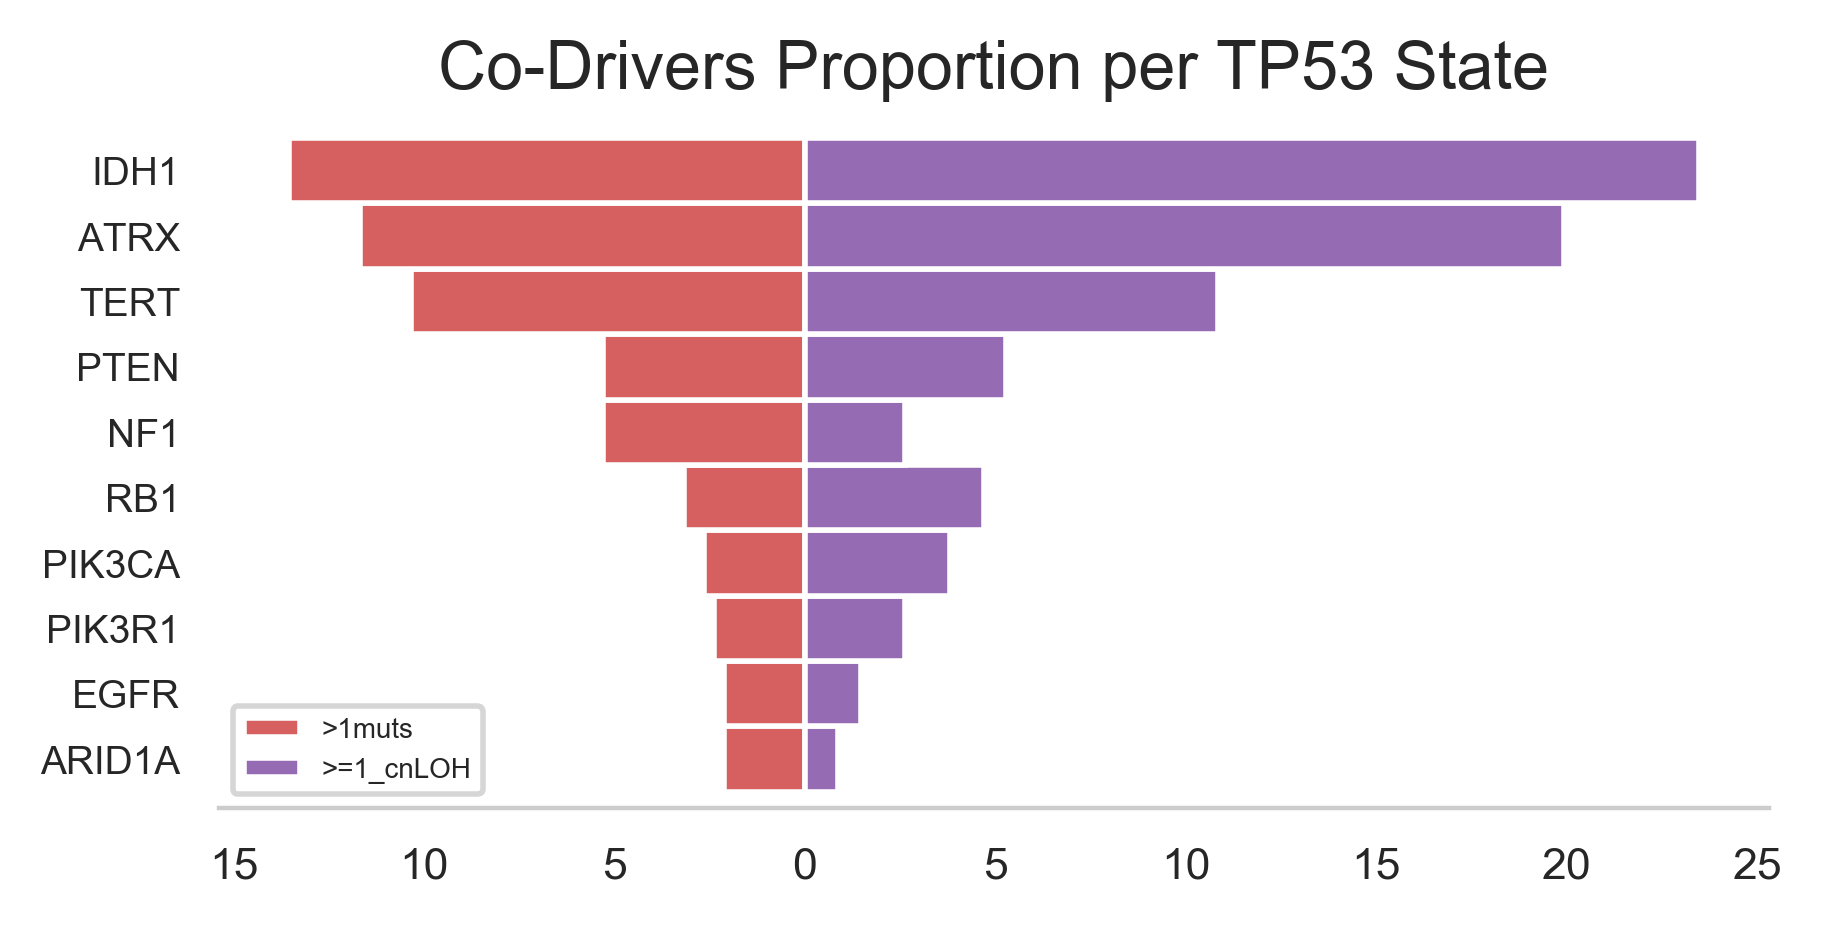

In [341]:
fig=plt.figure(figsize=(5,5))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_mult_cnloh[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[3],mc[4]])
ax.legend(['>1muts', '>=1_cnLOH'], fontsize=5)
ax.set_title('Co-Drivers Proportion per TP53 State')

plt.yticks(fontsize=7)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [20, 15, 10, 5, 0, 5, 10, 15, 20, 25, 30]
ax.set_xticklabels(a, fontsize=8)
plt.grid(b=None)

plt.show()

* Same pattern of co-drivers distribution
---

In [337]:
co_drivers_wt_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='1_WILD_TYPE',
                                                group_2='>=1_LOSS')
co_drivers_wt_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
TERT,57,-25.45,48,26.37
PTEN,20,-8.93,29,15.93
EGFR,13,-5.80,2,1.10
PIK3CA,10,-4.46,2,1.10
IDH1,10,-4.46,4,2.20
NF1,10,-4.46,13,7.14
PIK3R1,7,-3.12,8,4.40
RB1,5,-2.23,25,13.74
ATM,5,-2.23,1,0.55


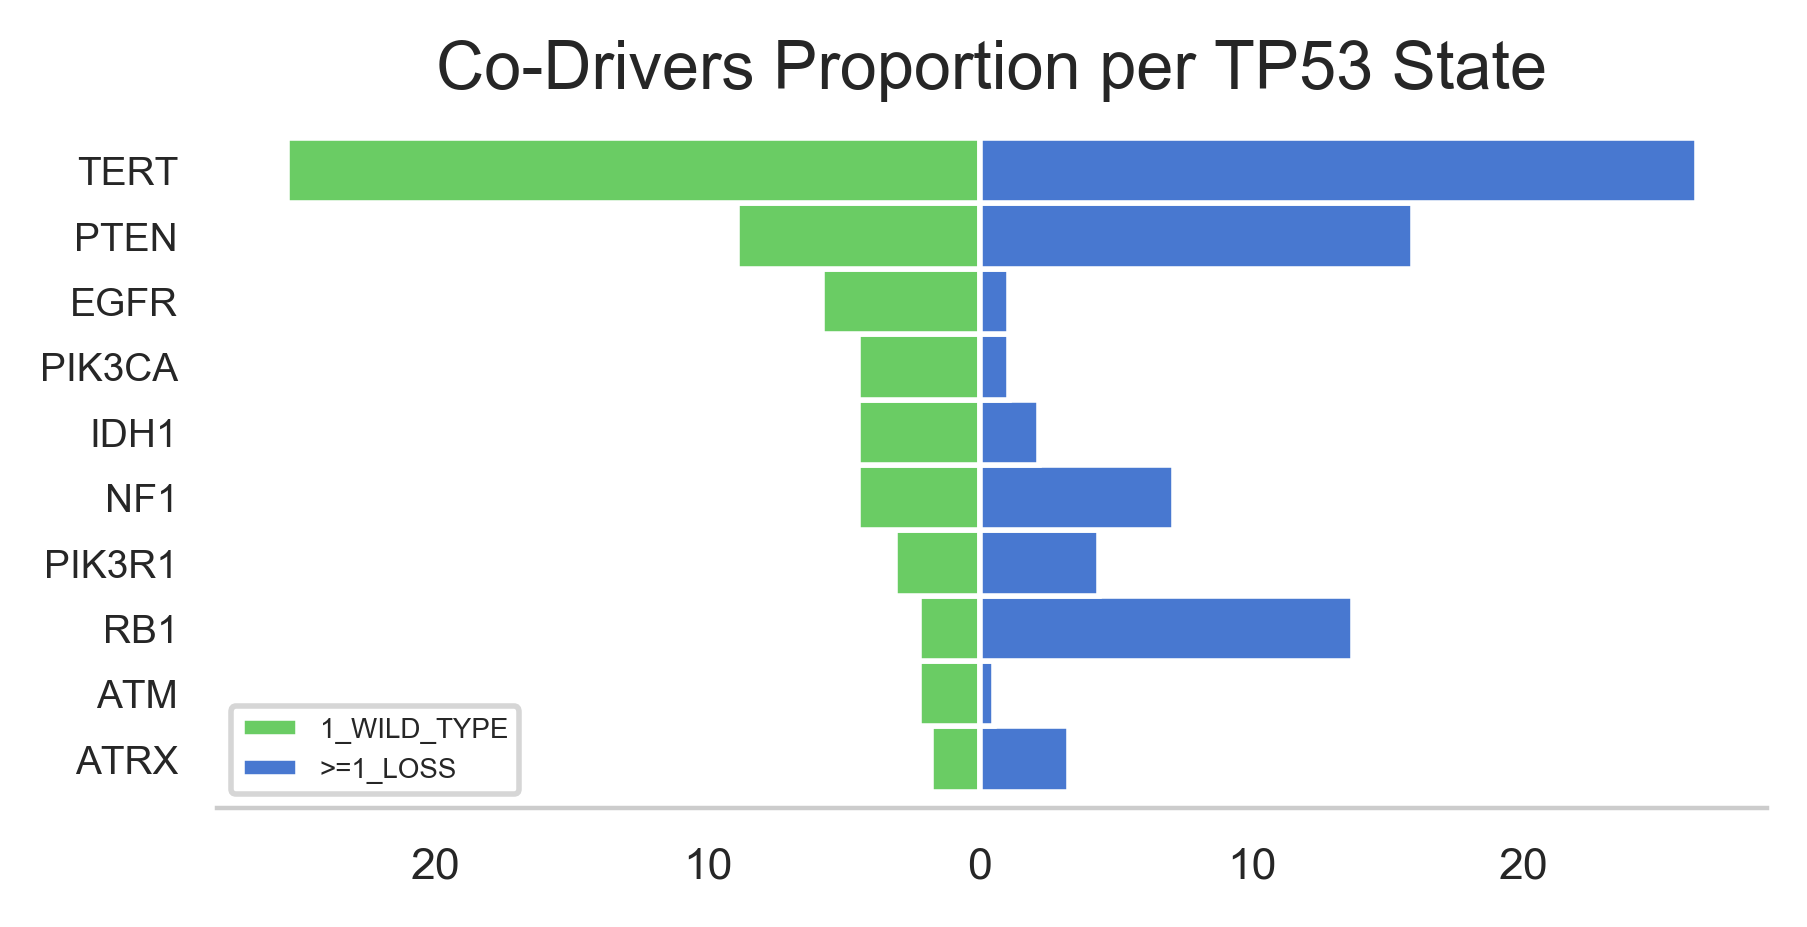

In [340]:
fig=plt.figure(figsize=(5,5))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wt_loss[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[2],mc[0]])
ax.legend(['1_WILD_TYPE', '>=1_LOSS'], fontsize=5)
ax.set_title('Co-Drivers Proportion per TP53 State')

plt.yticks(fontsize=7)
ax.set_ylabel('')
a=ax.get_xticks().tolist()

a = [30, 20, 10, 0, 10, 20, 30]
ax.set_xticklabels(a, fontsize=8)
plt.grid(b=None)

plt.show()

#### Comparison with WGD Cohort (WGD - )

### Genome Instability Associated

In [295]:
def get_master_codrivers(master: pd.DataFrame, maf: pd.DataFrame, symbol: str):
    samples = master.Tumor_Id.tolist()
    samples_final = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['Hugo_Symbol'] == symbol].Tumor_Sample_Barcode.tolist()

    master_filtered = master[master.Tumor_Id.isin(samples_final)]
    
    return master_filtered

#### >=1_cnLOH

In [315]:
master_no_wgd_cancer_cnloh = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_cnLOH']
master_IDH1 = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='IDH1')

master_ATRX = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='ATRX')

master_TERT = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='TERT')

master_no_wgd_cancer_cnloh['data'] = '>=1_cnLOH'
master_IDH1['data'] = 'IDH1'
master_ATRX['data'] = 'ATRX'
master_TERT['data'] = 'TERT'

masters = [master_no_wgd_cancer_cnloh, master_IDH1, master_ATRX, master_TERT]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

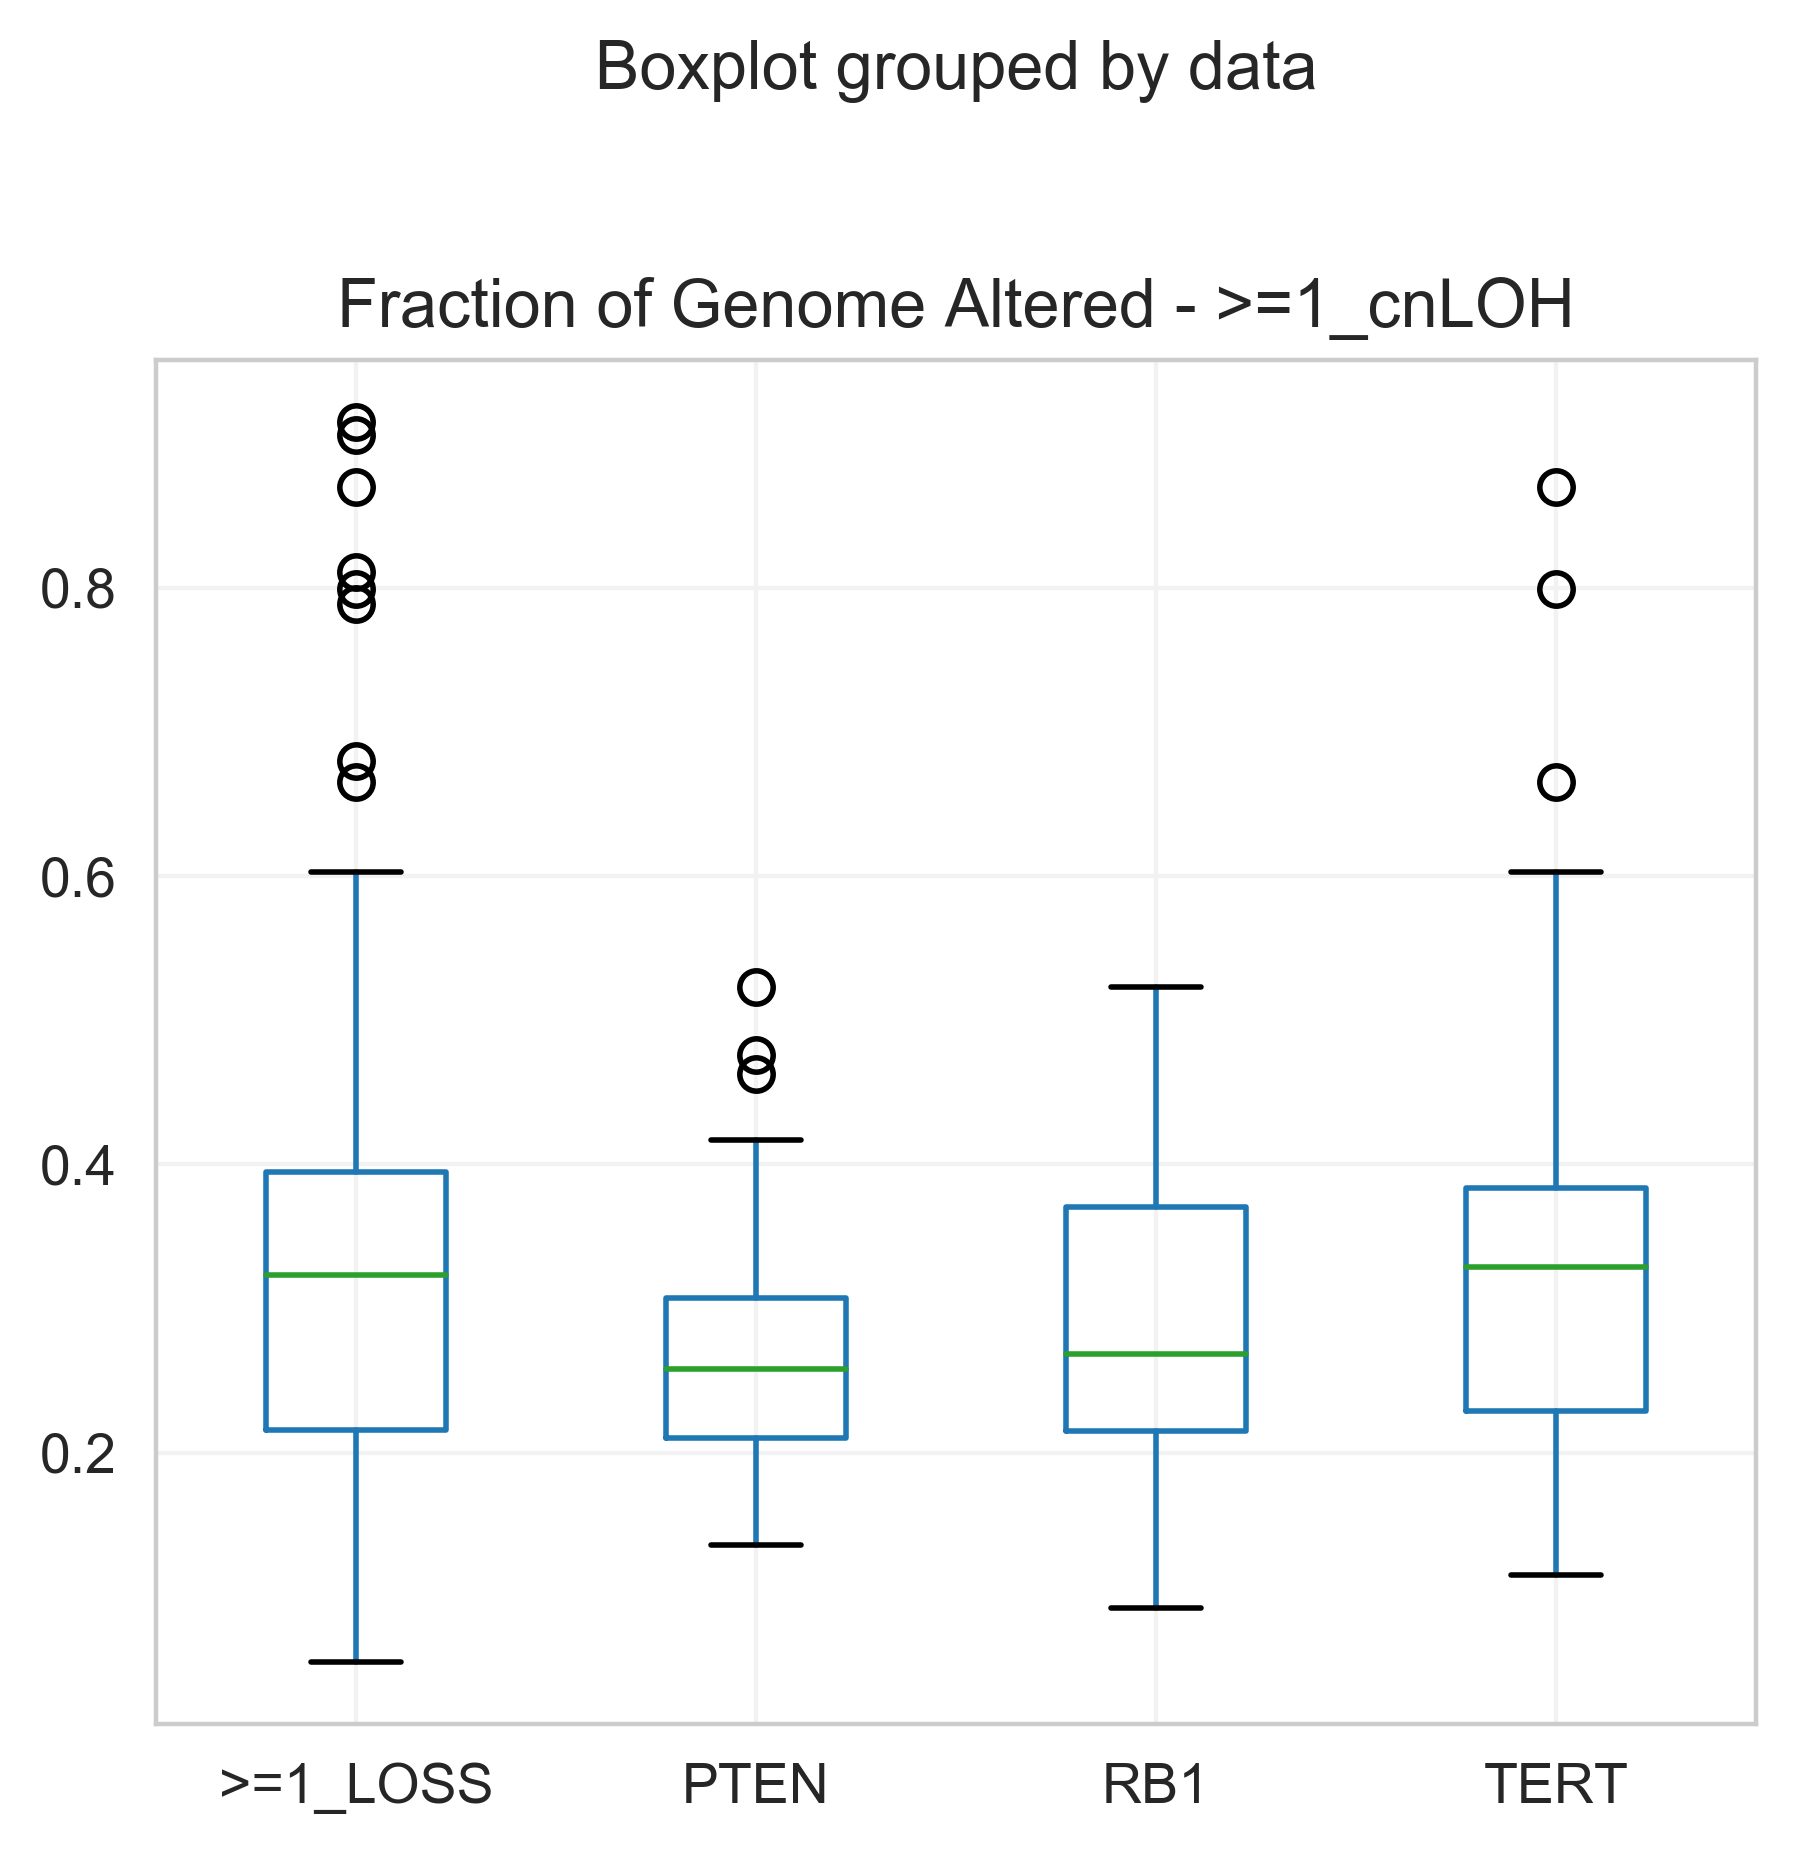

In [342]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_cnLOH')
ax.set_xlabel('')

#### >=1_LOSS

In [318]:
master_no_wgd_cancer_loss = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_LOSS']
master_TERT = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='TERT')

master_PTEN = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='PTEN')

master_RB1 = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='RB1')

master_no_wgd_cancer_loss['data'] = '>=1_LOSS'
master_TERT['data'] = 'TERT'
master_PTEN['data'] = 'PTEN'
master_RB1['data'] = 'RB1'


masters = [master_no_wgd_cancer_loss, master_TERT, master_PTEN, master_RB1]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

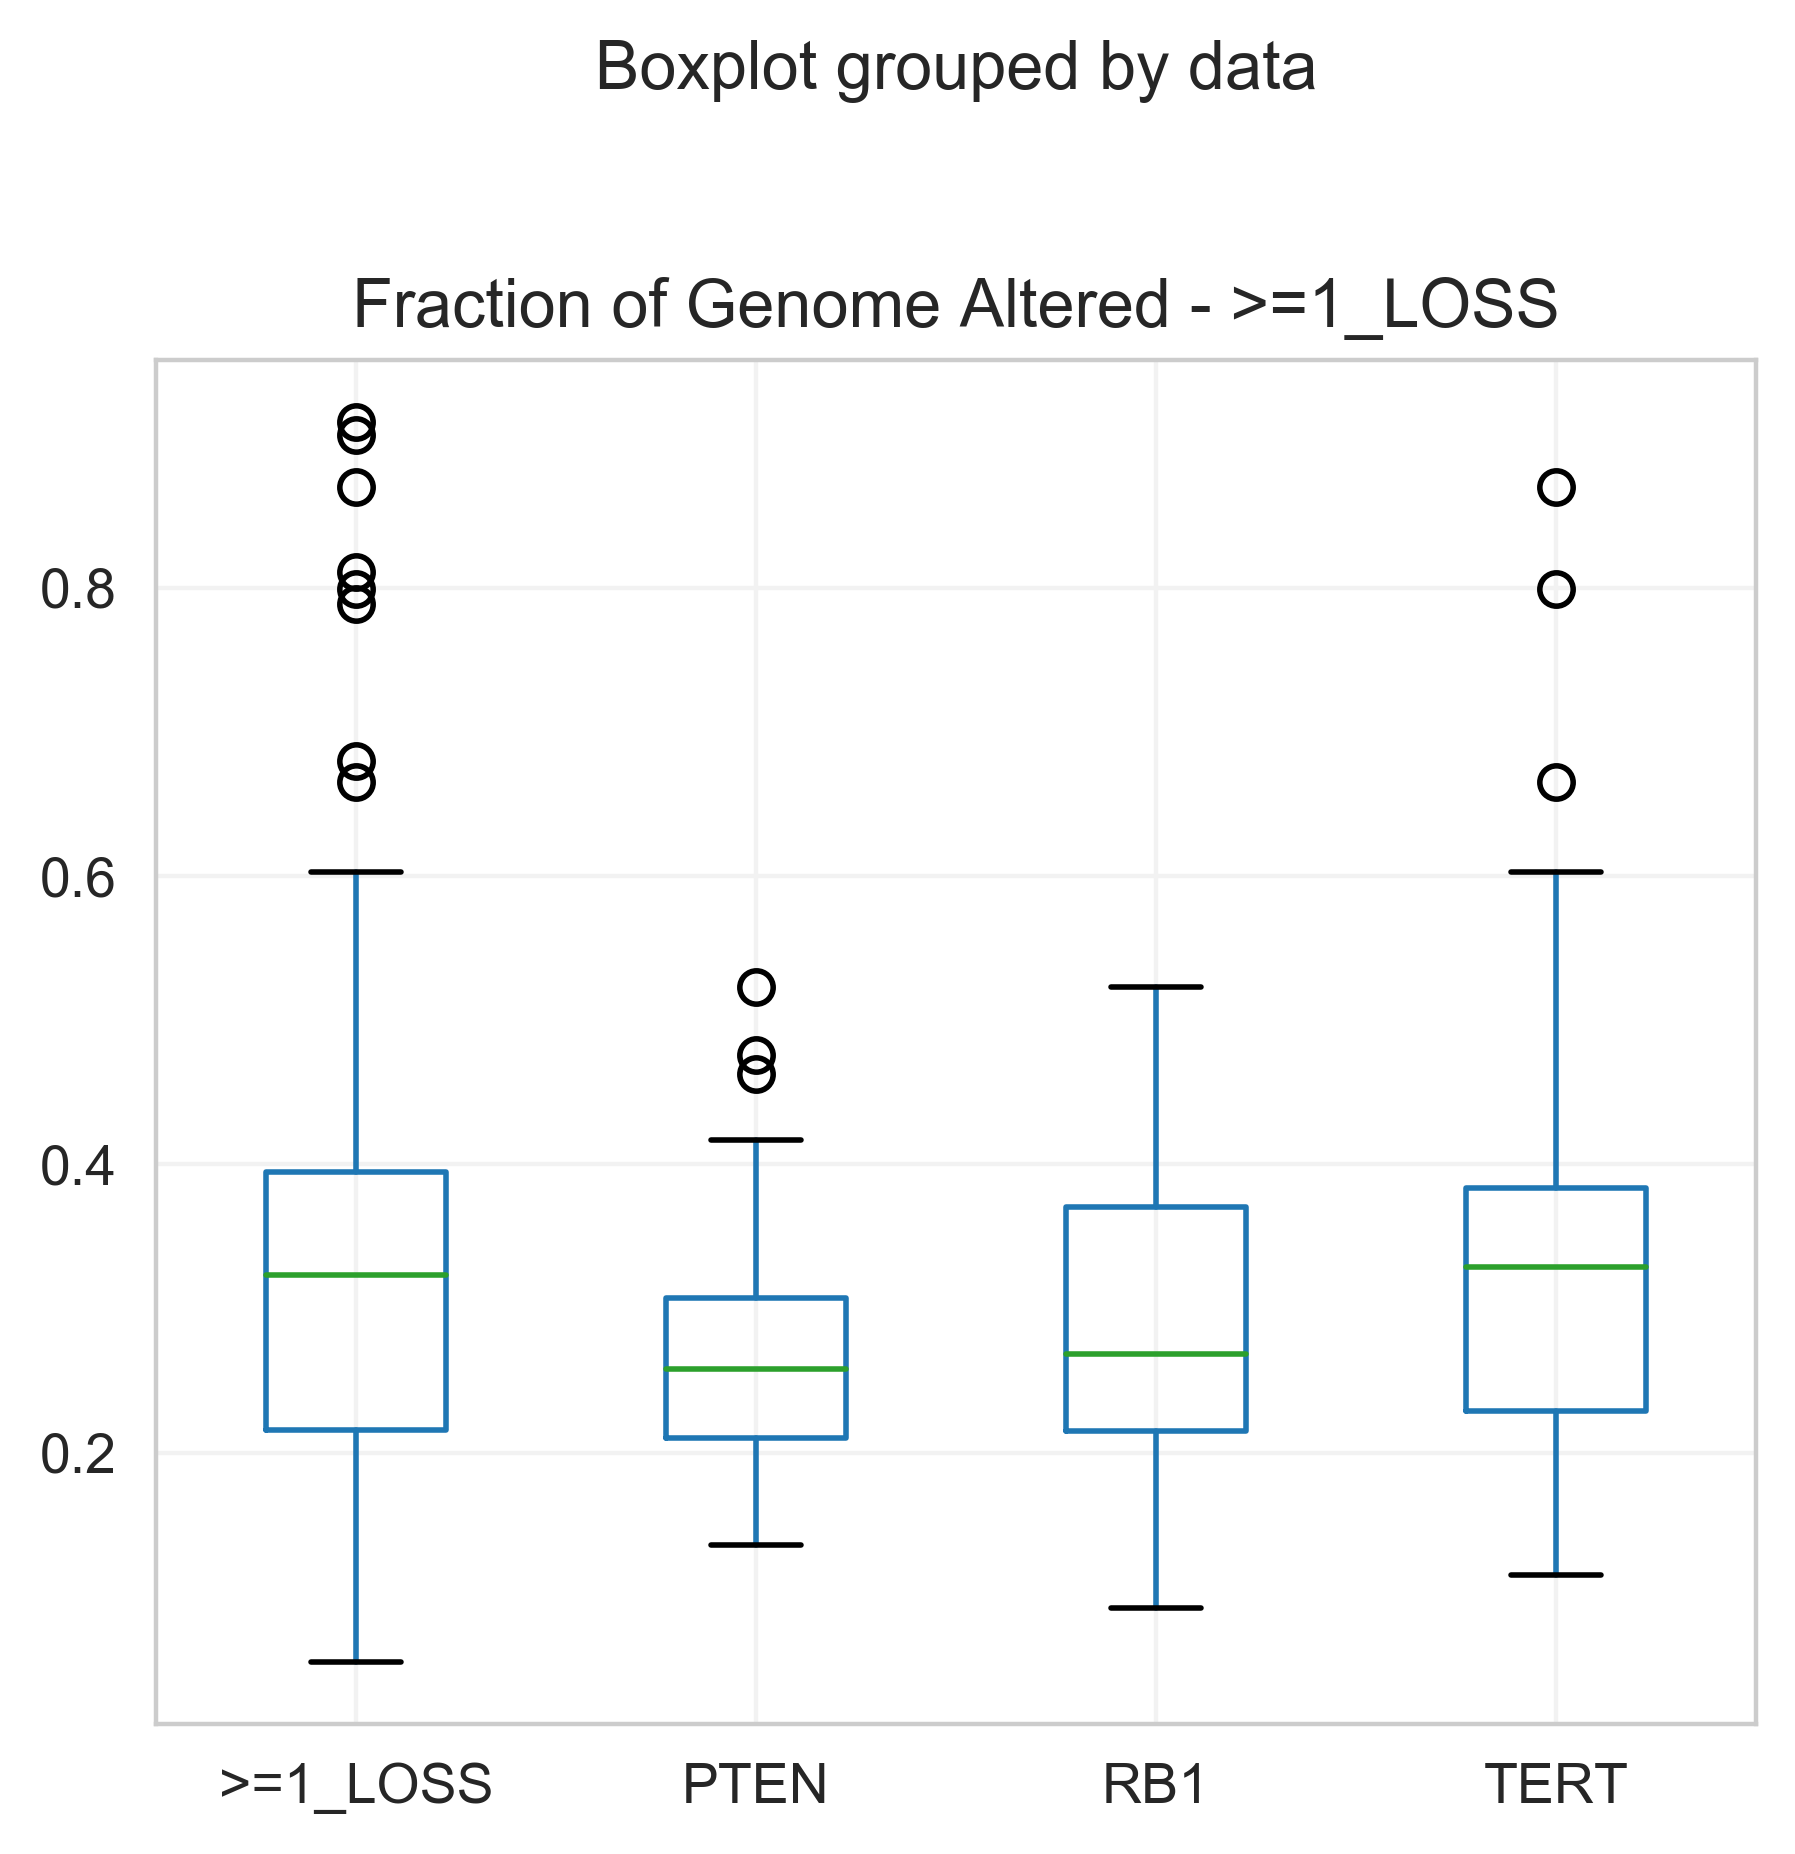

In [319]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_LOSS')
ax.set_xlabel('')

#### >1muts

In [343]:
master_no_wgd_cancer_muts = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts']
master_IDH1 = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='IDH1')

master_ATRX = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='ATRX')

master_TERT = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='TERT')

master_no_wgd_cancer_muts['data'] = '>1muts'
master_IDH1['data'] = 'IDH1'
master_ATRX['data'] = 'ATRX'
master_TERT['data'] = 'TERT'

masters = [master_no_wgd_cancer_muts, master_IDH1, master_ATRX, master_TERT]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

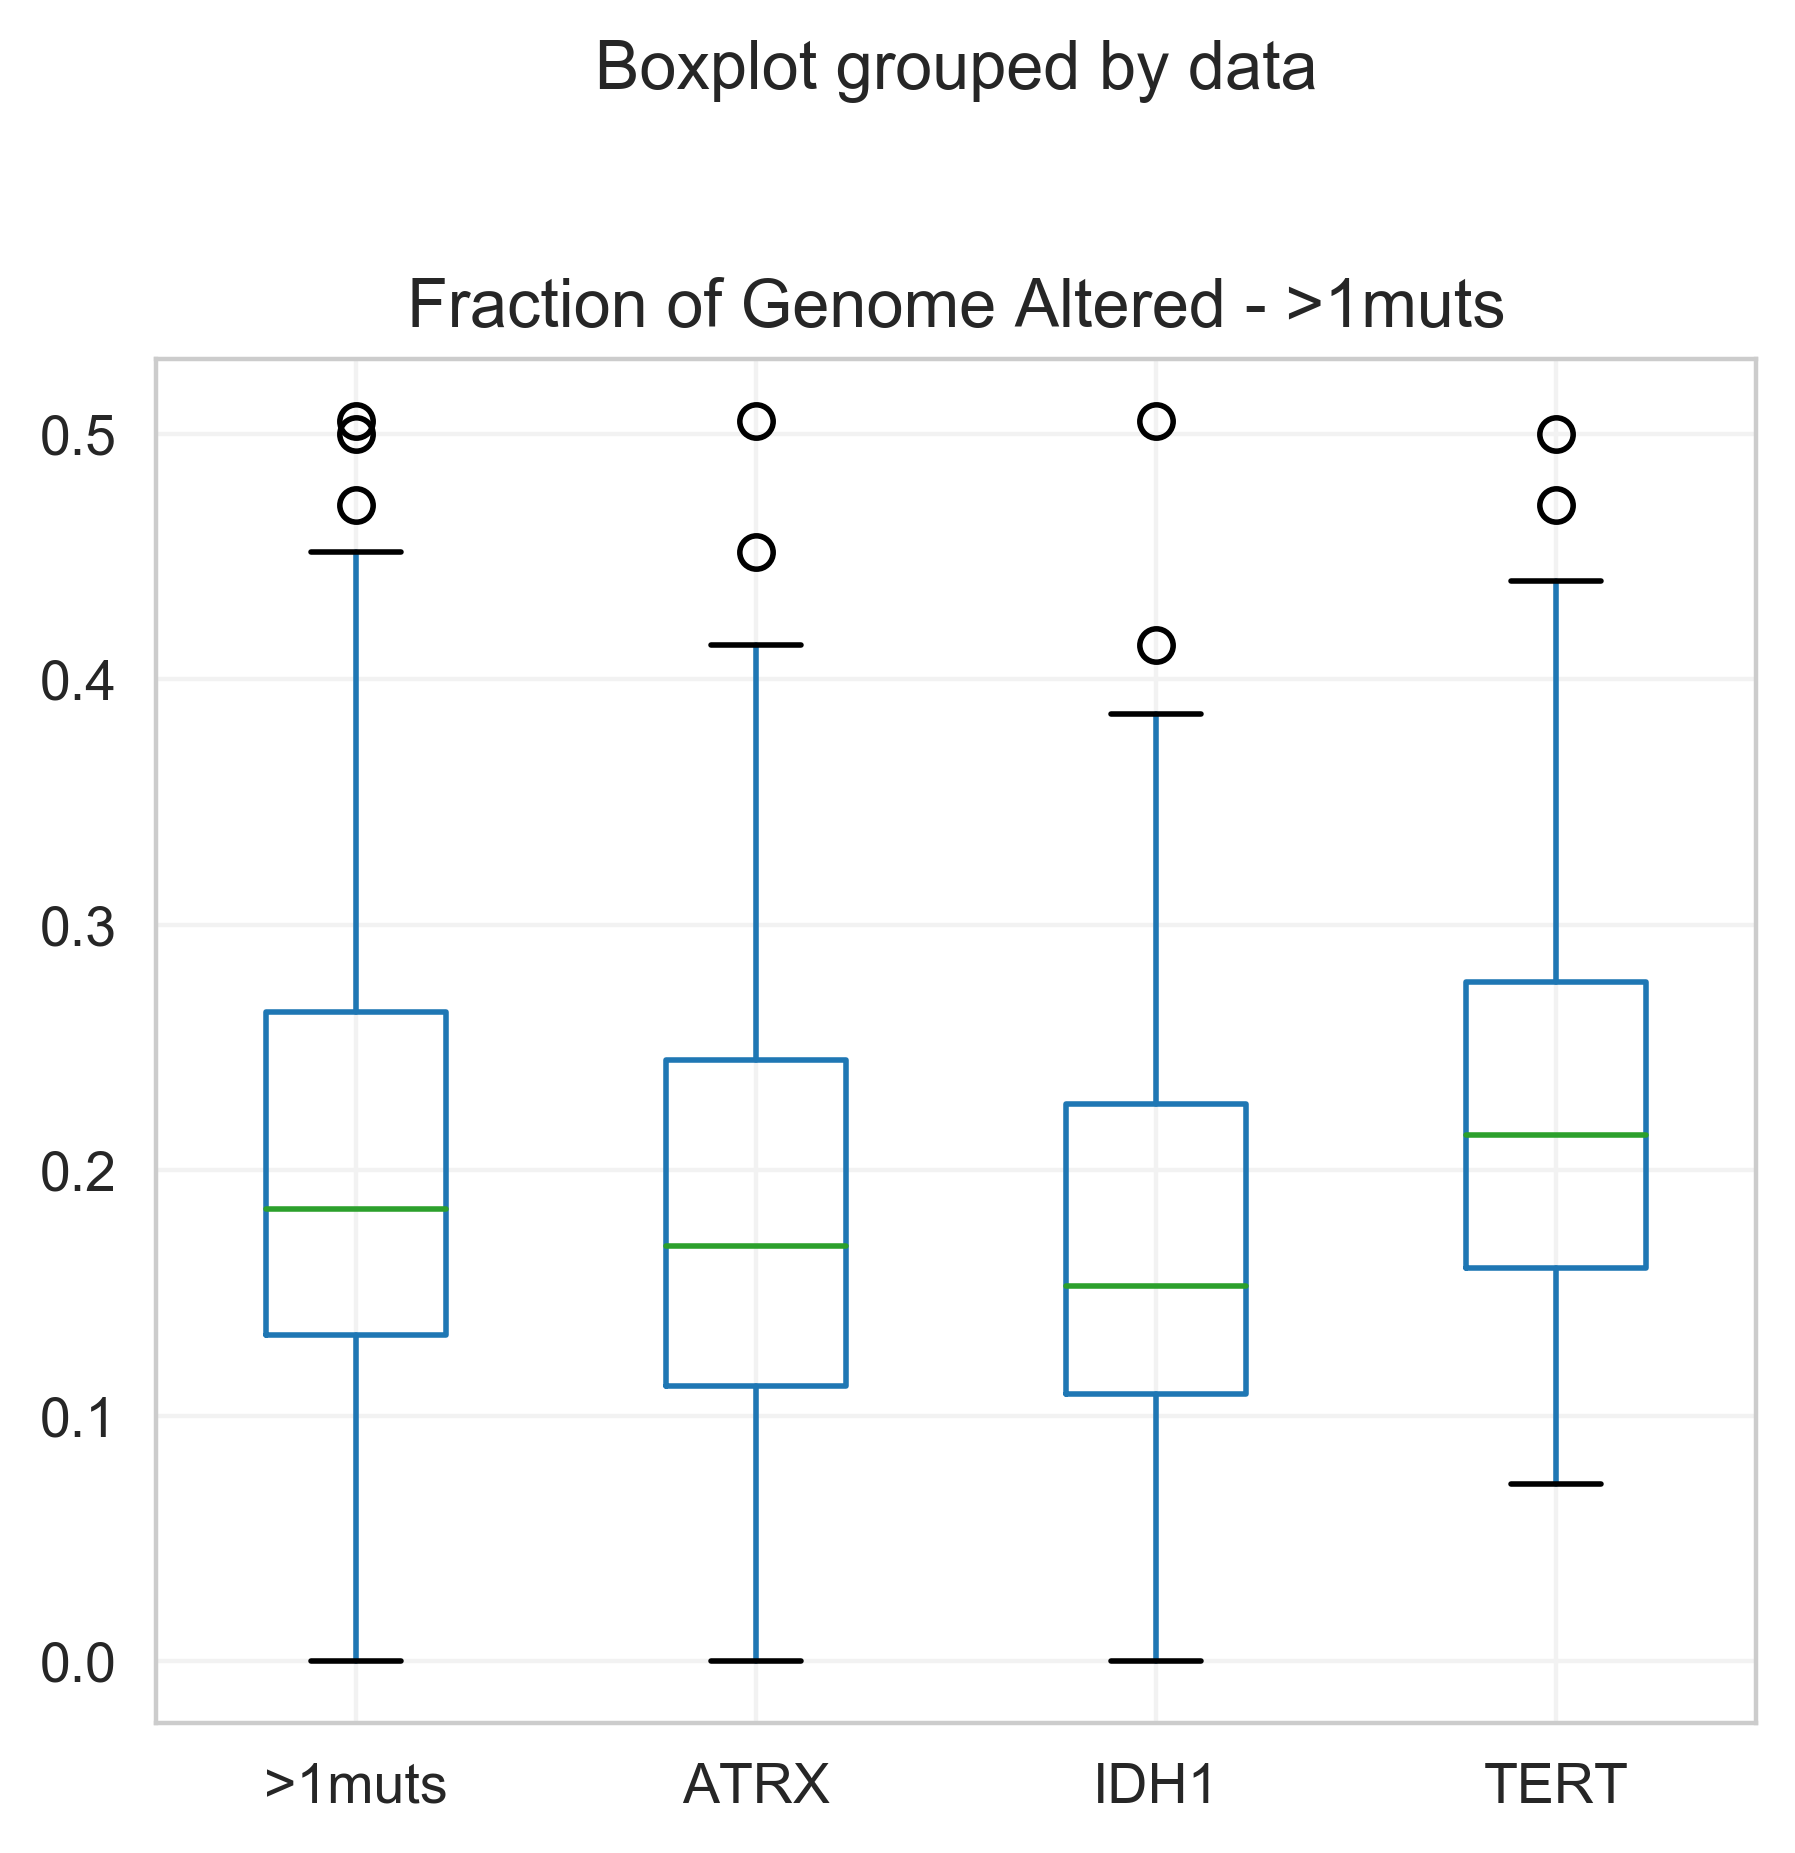

In [344]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >1muts')
ax.set_xlabel('')

## CCF / VAF Analysis
Same here we take only samples with exactly 1 tp53 mutation (*master_hotspot*).

We have to define groups for CCF to see if there are differences between those groups. To have an idea of the CCF distribution we show here the distribution coming from the *cancer_panel*.

<img src='glioma_ccf.png' width=1000 length=1000>

We see that our tp53_ccf distribution is very high for all subgroups except for *1_WILD_TYPE*.

It will be hard to cut the cohort based on the CCF. Let's try and see the size of the subcohorts:

In [32]:
master_ccf = master_no_wgd_cancer[(master_no_wgd_cancer['tp53_count'] == 1) | (master_no_wgd_cancer['tp53_group'] == '0_HETLOSS')]

In [39]:
thr_ccf_1 = 0.90 ; thr_ccf_2 = 0.95

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 <= thr_ccf_2: return 'medium'
    elif x.tp53_ccf_1 > thr_ccf_2: return 'high'

master_ccf['ccf_group'] = master_ccf.apply(ccf_subgroup, axis=1)
get_groupby(master_ccf, 'ccf_group', 'count')

,count
ccf_group,
high,188
low,47
medium,21


In [40]:
thr_vaf_1 = 0.3 ; thr_vaf_2 = 0.4

def vaf_subgroup(x):
    if x.tp53_vaf_1 <= thr_vaf_1: return 'low'
    elif x.tp53_vaf_1 <= thr_vaf_2: return 'medium'
    elif x.tp53_vaf_1 > thr_vaf_2: return 'high'

master_ccf['vaf_group'] = master_ccf.apply(vaf_subgroup, axis=1)       
get_groupby(master_ccf, 'vaf_group', 'count')

,count
vaf_group,
high,173
low,56
medium,30


### VAF Analysis

#### No VAF Cut

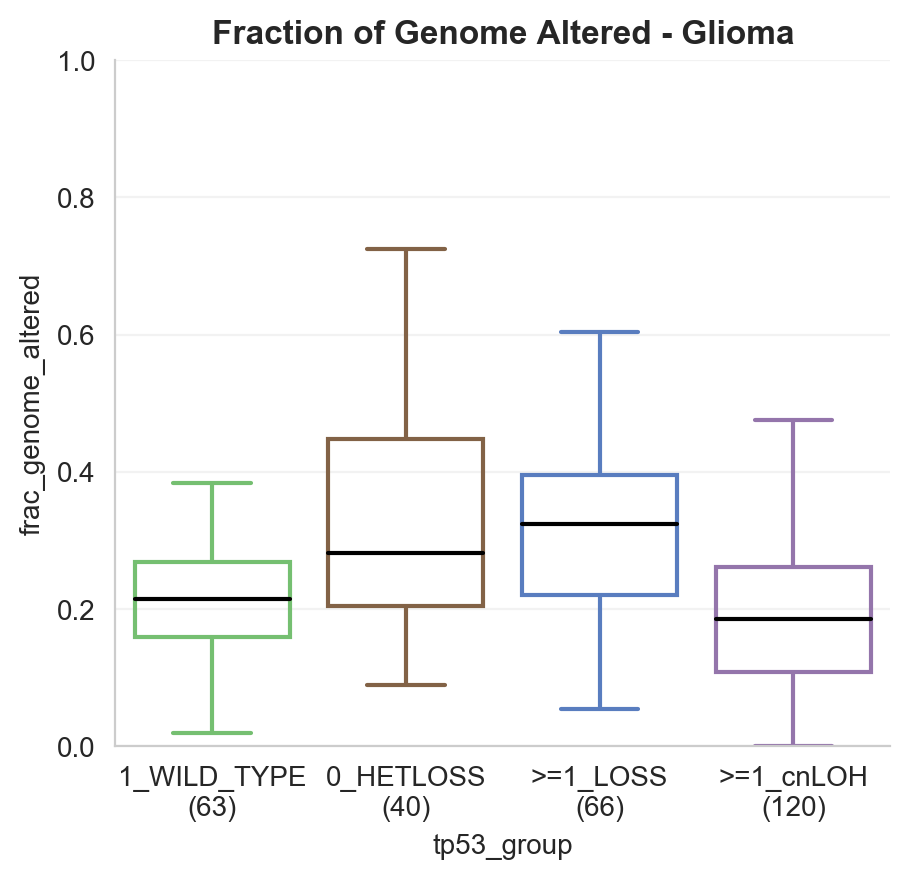

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,40,0.2815
2,1_WILD_TYPE,63,0.215
3,,Statistics,p-value
4,,3.45099,0.000558532


In [41]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low VAF

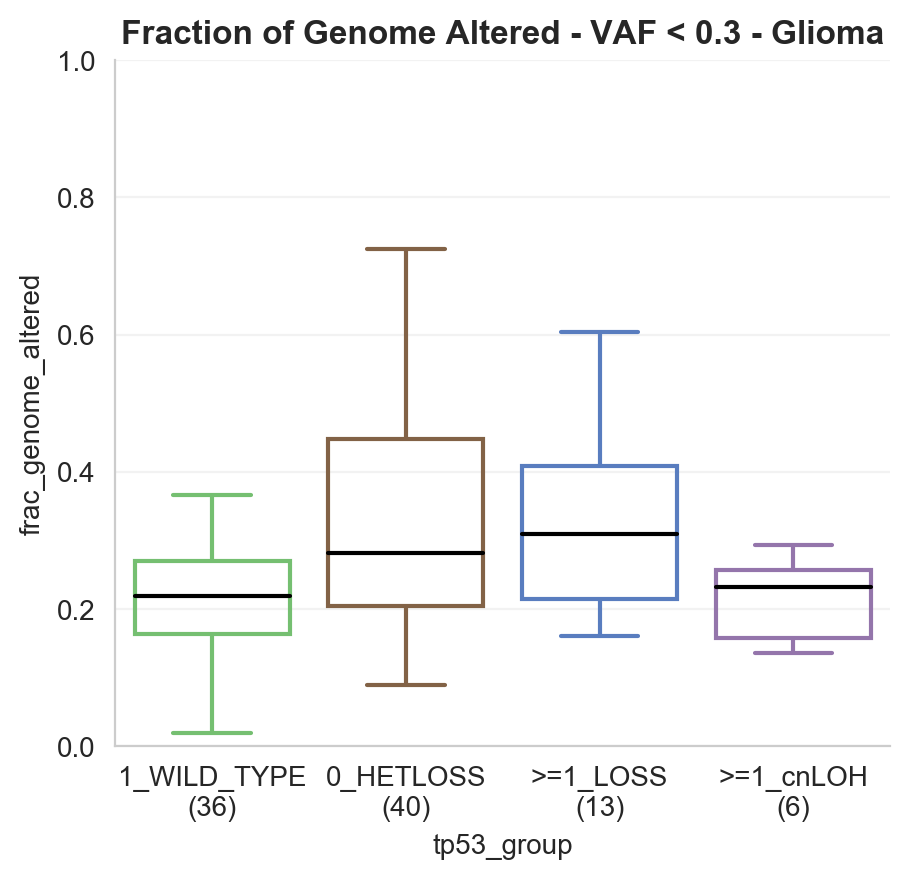

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,36,0.219
2,>=1_LOSS,13,0.31
3,,Statistics,p-value
4,,-2.51366,0.0119487


In [42]:
master_low = master_ccf[(master_ccf['vaf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF < {} - {}'.format(thr_vaf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

#### Medium VAF

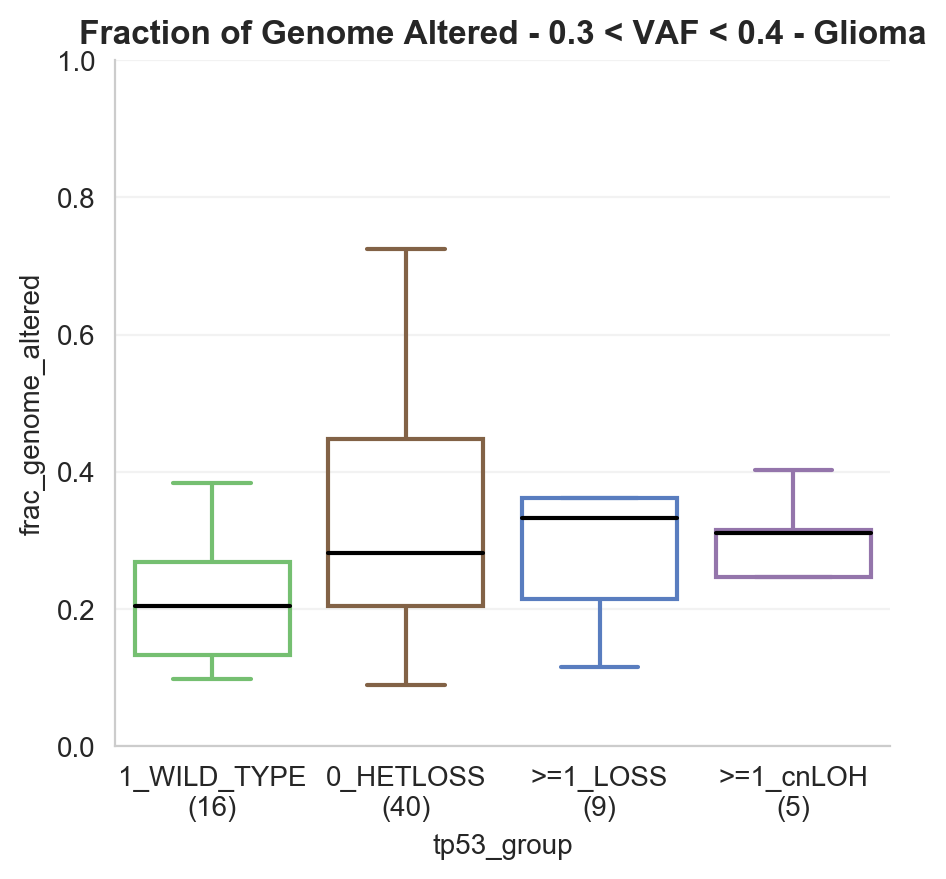

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,16,0.2045
2,0_HETLOSS,40,0.2815
3,,Statistics,p-value
4,,-2.5301,0.0114031


In [43]:
master_med = master_ccf[(master_ccf['vaf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < VAF < {} - {}'.format(thr_vaf_1,thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High VAF

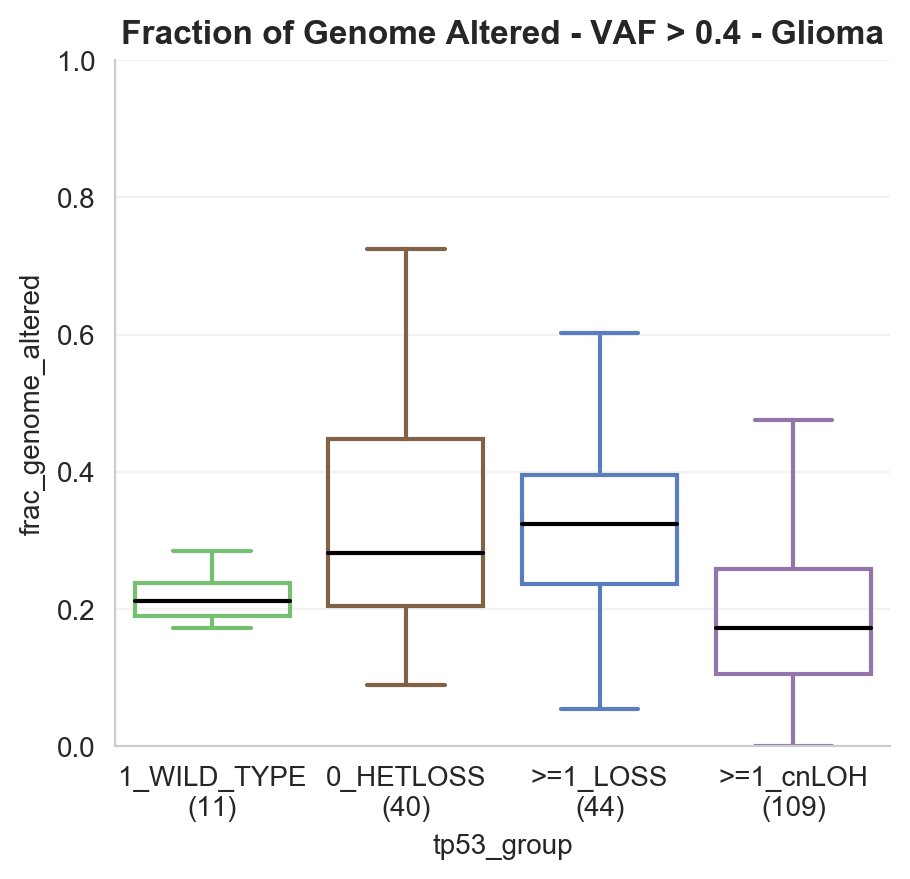

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,11,0.211
2,0_HETLOSS,40,0.2815
3,,Statistics,p-value
4,,-1.85502,0.063594


In [44]:
master_high = master_ccf[(master_ccf['vaf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF > {} - {}'.format(thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### CCF Analysis

#### No CCF Cut

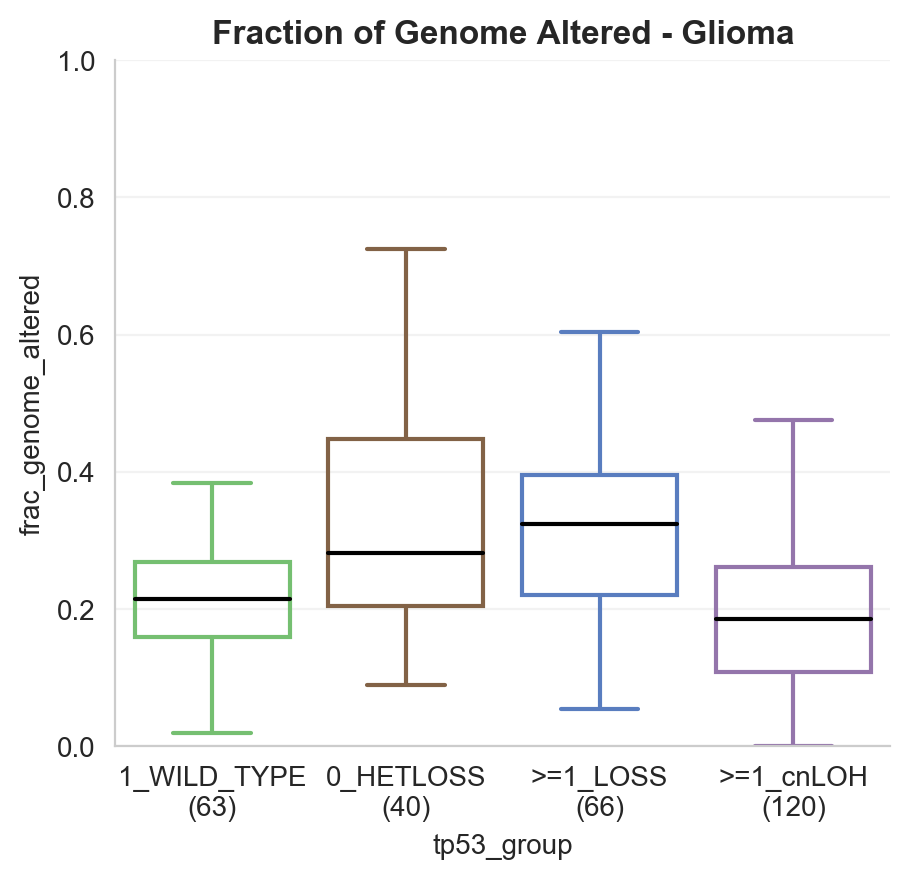

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,40,0.2815
2,1_WILD_TYPE,63,0.215
3,,Statistics,p-value
4,,3.45099,0.000558532


In [45]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low CCF

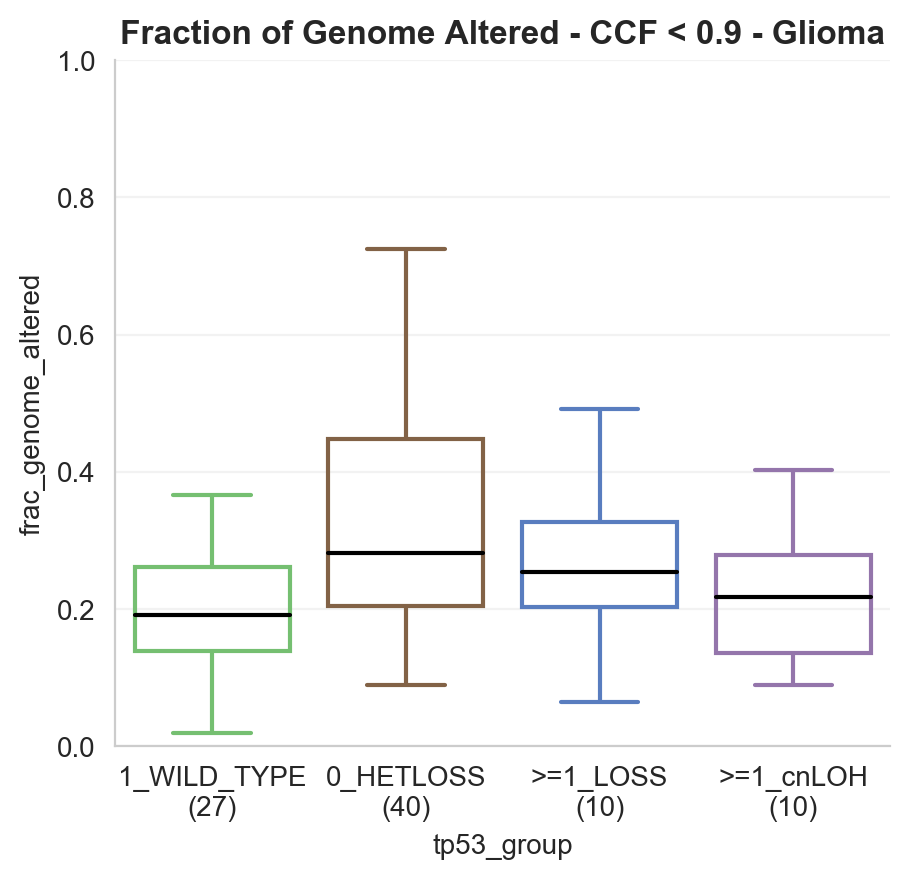

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,27,0.191
2,0_HETLOSS,40,0.2815
3,,Statistics,p-value
4,,-3.707,0.000209731


In [46]:
master_low = master_ccf[(master_ccf['ccf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF < {} - {}'.format(thr_ccf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### Medium CCF

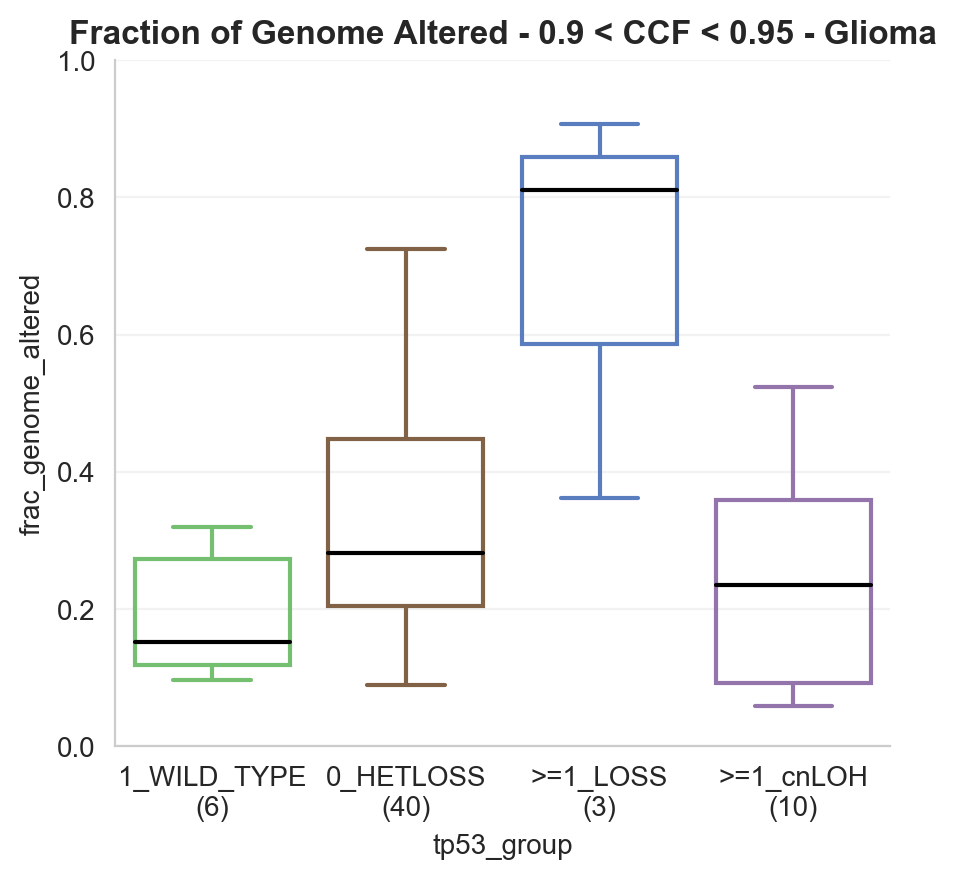

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,6,0.1515
2,0_HETLOSS,40,0.2815
3,,Statistics,p-value
4,,-2.1853,0.0288669


In [47]:
master_med = master_ccf[(master_ccf['ccf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < CCF < {} - {}'.format(thr_ccf_1,thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High CCF

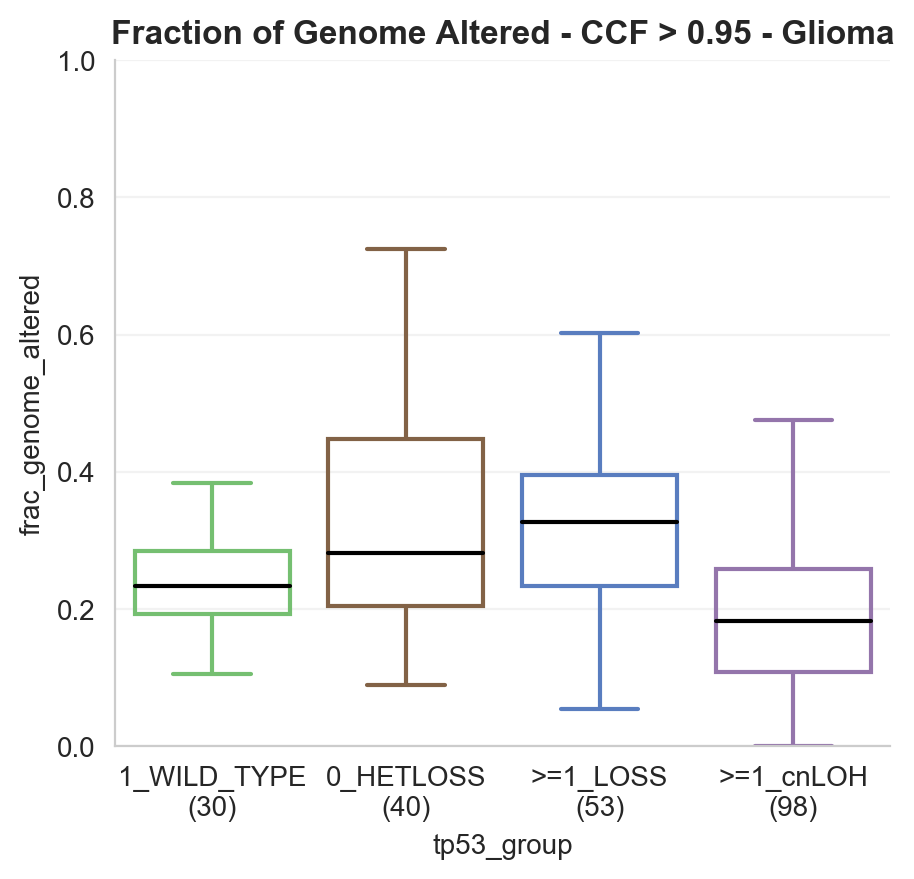

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,30,0.2335
2,0_HETLOSS,40,0.2815
3,,Statistics,p-value
4,,-1.81578,0.0694047


In [48]:
master_high = master_ccf[(master_ccf['ccf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF > {} - {}'.format(thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### Splitting on the different level of CCF / VAF

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='vaf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - VAF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='vaf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='ccf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - CCF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='ccf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

## >=1_cnLOH Subgroup investigation
Something weird happens with >=1_cnLOH. Indeed, this subgroup has a very low Fraction of Genome Altered, but in the meantime it is the subgroup with the lowest median Age. This is counterintuitive ... 
Let's try to see which part of >=1_cnLOH is leading the signal

### Hotspots

In [63]:
master_hotspot_cnloh = master_hotspot[master_hotspot['tp53_group'] == '>=1_cnLOH']

In [64]:
get_hotspot_frac(df=master_hotspot_cnloh,
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,273,22,0.1345
2,248,10,0.1195
3,193,6,0.1855
4,282,5,0.213
5,175,4,0.1375
6,nan,3,0.343
7,255,3,0.431
8,176,3,0.156
9,157,3,0.179


,count
tp53_vc_group_1,
missense,49
273,22
truncated,18
248,10
in_frame,9
hotspot,8
175,4


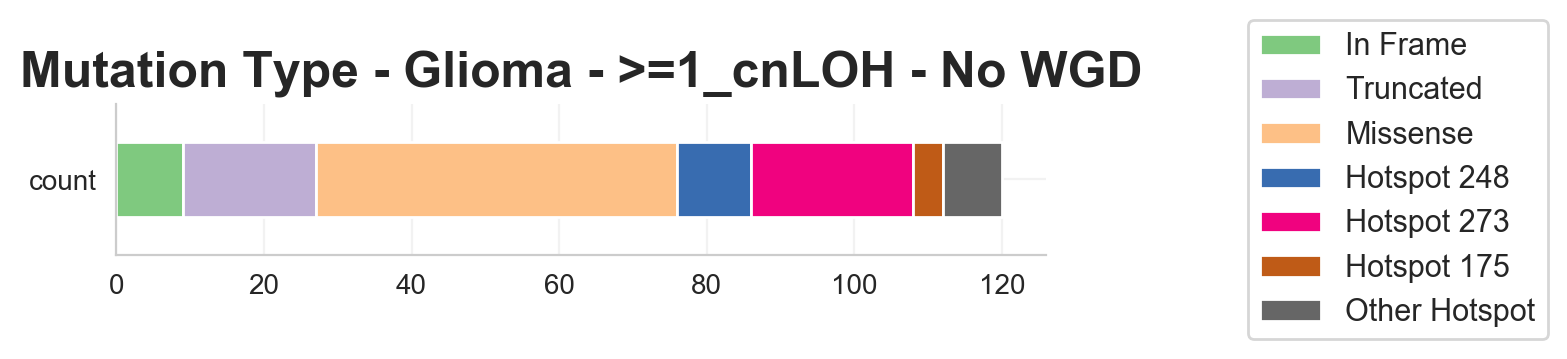

In [66]:
h = get_groupby(master_hotspot_cnloh,'tp53_vc_group_1', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[mutation_list]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=11)
ax.set_title('Mutation Type - {} - >=1_cnLOH - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

In comparison with the entire Glioma cohort, we have a clear enrichment in Hotspot 273 (22 out of 29 are in >=1_cnLOH subgroup)
* 273 / 248 are associated with low Genome Instability
* 193 / 282  with higher GI

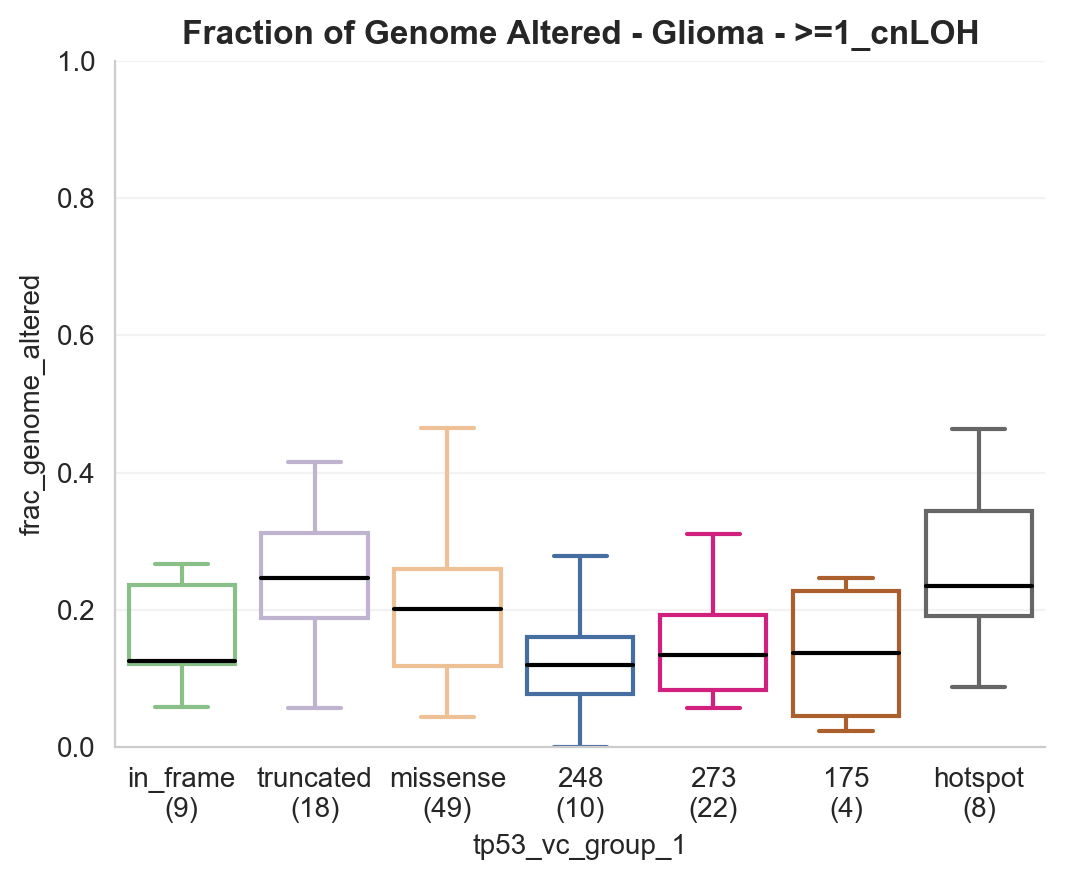

In [68]:
fig, ax = boxplot_sampletype(df=master_hotspot_cnloh,
                  group='tp53_vc_group_1',
                  palette=mutation_palette,
                  order=mutation_list,
                  metrics='frac_genome_altered',
                  figsize=(6,10),
                  title='Fraction of Genome Altered - {} - >=1_cnLOH'.format(cancer),
                  xlim=[0,1])
plt.show()

### Main Co-Drivers
In this section, we want to see what are the main co-drivers in >=1_cnLOH subgroup.

In [73]:
h = master_hotspot_cnloh.driver_gene_count.mean()
print('Each >=1_cnLOH sample as an average of ' + str(h) + ' co-driver genes')

Each >=1_cnLOH sample as an average of 2.55 co-driver genes


In [100]:
def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10):
    samples = master.Tumor_Id.tolist()
    maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)

#### Co-Drivers Count per Gene

In [134]:
get_major_codrivers(master=master_hotspot_cnloh,
                    maf=maf_cohort_nowgd,
                    head=10)

,count
Hugo_Symbol,
IDH1,77
ATRX,65
TERT,32
PTEN,17
RB1,13
PIK3CA,12
PIK3R1,9
NF1,8
ARID2,6


In [106]:
get_major_codrivers(master=master_hotspot,
                    maf=maf_cohort_nowgd,
                    head=10)

,count
Hugo_Symbol,
TERT,137
IDH1,97
ATRX,76
PTEN,67
RB1,43
NF1,28
PIK3CA,25
PIK3R1,23
EGFR,20


In comparison with entire Glioma Cohort:
* Enrichment in **IDH1** / **ATRX**
* Depletion in **TERT** 

#### Cut the cohort

In [113]:
symbol = 'IDH1'
master = master_hotspot_cnloh
maf=maf_cohort_nowgd

def get_master_codrivers(master: pd.DataFrame, maf: pd.DataFrame, symbol: str):
    samples = master.Tumor_Id.tolist()
    samples_final = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['Hugo_Symbol'] == symbol].Tumor_Sample_Barcode.tolist()

    master_filtered = master[master.Tumor_Id.isin(samples_final)]
    
    return master_filtered

In [127]:
master_IDH1 = get_master_codrivers(master=master_hotspot_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='IDH1')

master_ATRX = get_master_codrivers(master=master_hotspot_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='ATRX')

master_TERT = get_master_codrivers(master=master_hotspot_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='TERT')

In [128]:
master_hotspot_cnloh.frac_genome_altered.median()

0.186

In [129]:
master_IDH1.frac_genome_altered.median()

0.138

In [130]:
master_ATRX.frac_genome_altered.median()

0.154

In [131]:
master_TERT.frac_genome_altered.median()

0.277

In [135]:
master_hotspot_cnloh['data'] = '>=1_cnLOH'
master_IDH1['data'] = 'IDH1'
master_ATRX['data'] = 'ATRX'
master_TERT['data'] = 'TERT'

masters = [master_hotspot_cnloh, master_IDH1, master_ATRX, master_TERT]
allMasters = pd.concat(masters)

<Figure size 600x600 with 0 Axes>

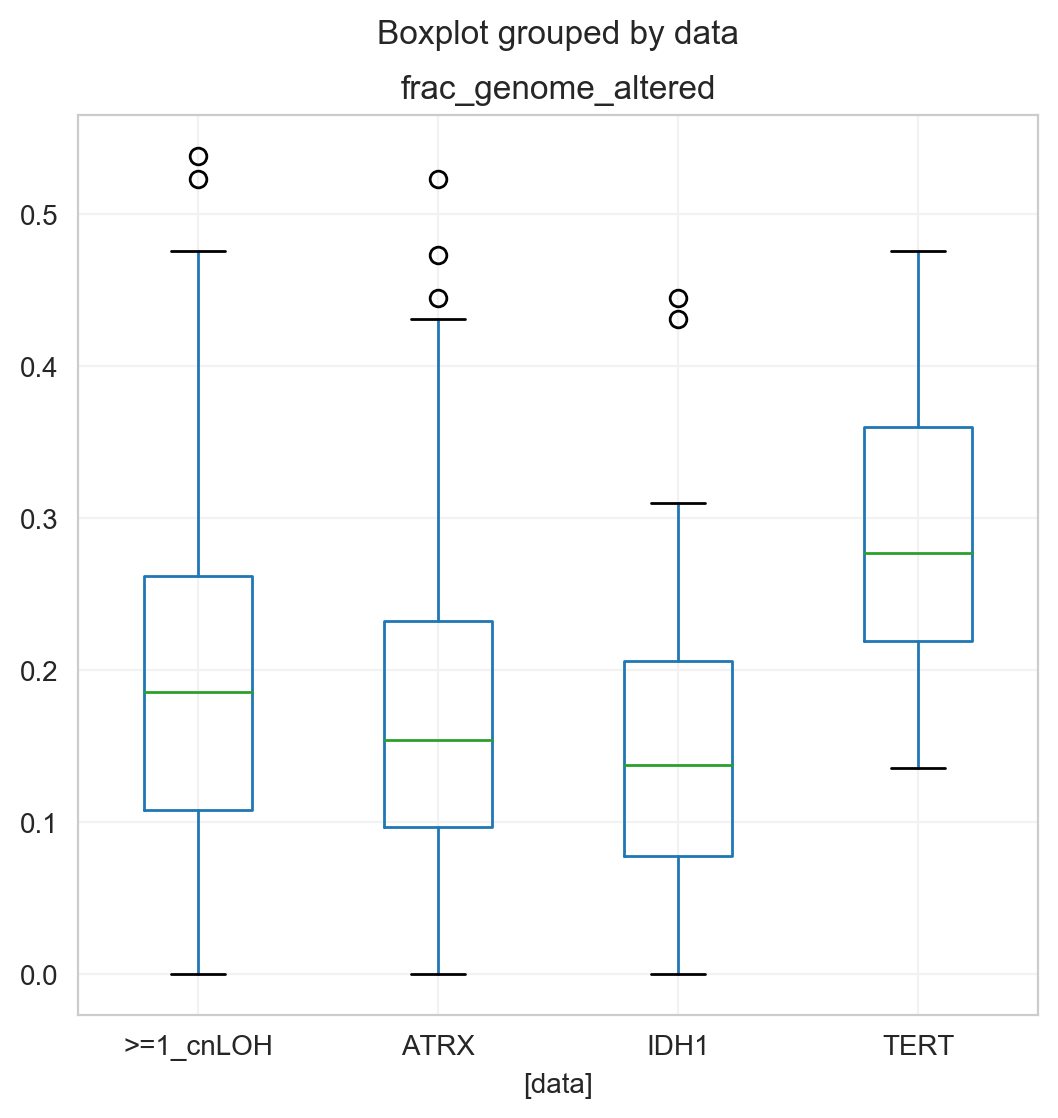

In [139]:
plt.figure()
allMasters[['frac_genome_altered', 'data']].boxplot(by="data")

## Clinical Correlates

### Age

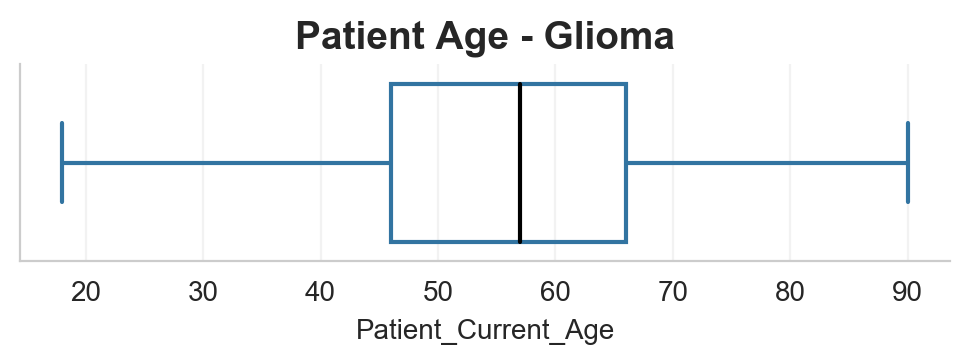

In [49]:
#### TP53 Residual Groups#fig=plt.figure(figsize=(10,3))
ax = plt.subplot2grid(shape=(4,1), loc=(0,0), colspan=1)

sns.boxplot(x='Patient_Current_Age',data=master_no_wgd_cancer, ax=ax).set_title('Patient Age - {}'.format(cancer), weight='bold', fontsize=14)


style(ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### TP53 Residual Groups

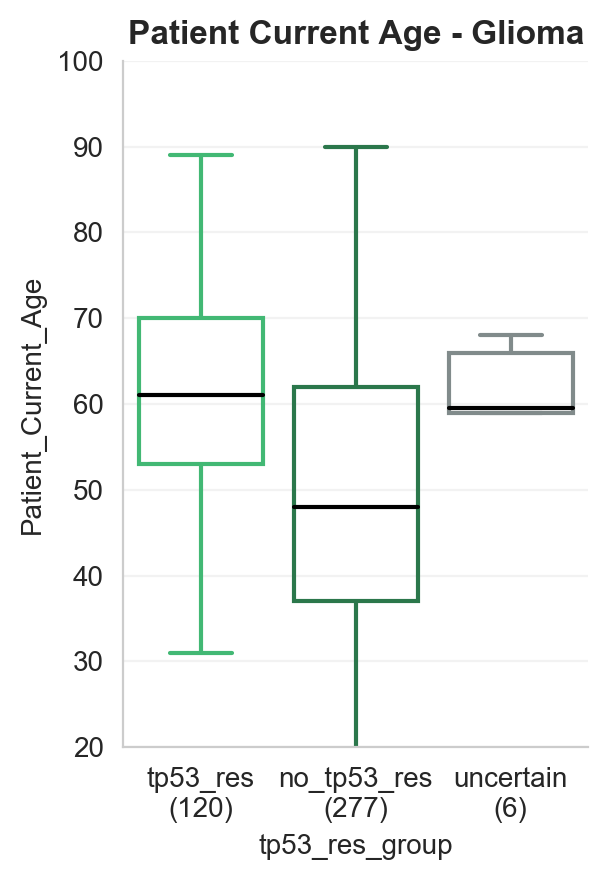

,0,1,2
0,,size,Patient_Current_Age
1,tp53_res,120,61
2,no_tp53_res,277,48
3,,Statistics,p-value
4,,6.01106,1.84313e-09


In [50]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_res_group',
                  palette=palette_res,
                  order=res_group_list,
                  metrics='Patient_Current_Age',
                  figsize=(3,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_res_group',
               metrics='Patient_Current_Age',
               group_list=['tp53_res', 'no_tp53_res'])#### TP53 Subgroups

#### TP53 Subgroups

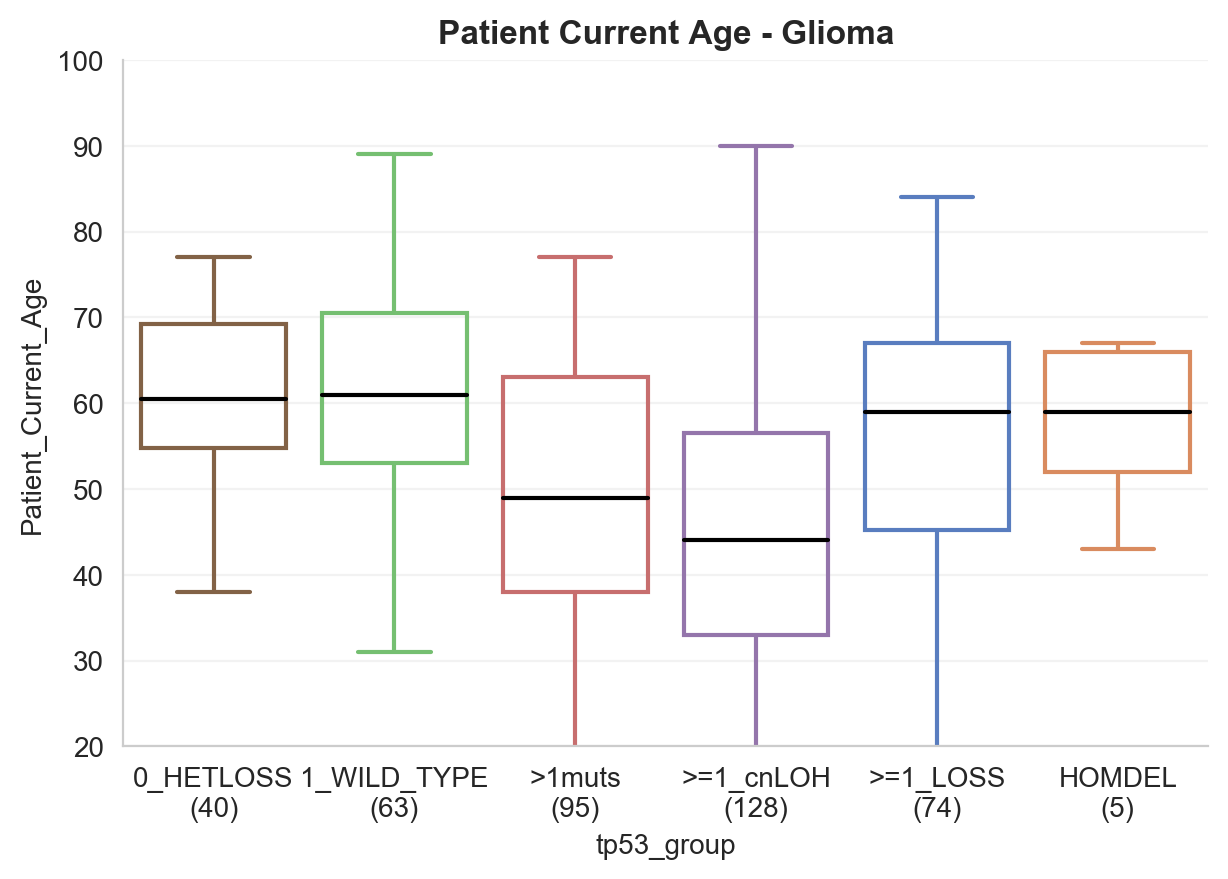

,0,1,2
0,,size,Patient_Current_Age
1,1_WILD_TYPE,63,61
2,>=1_cnLOH,128,44
3,,Statistics,p-value
4,,5.62919,1.81058e-08


In [51]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='Patient_Current_Age',
                  figsize=(7,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='Patient_Current_Age',
               group_list=['1_WILD_TYPE', '>=1_cnLOH'])

### Sex

,count
Sex,
Male,704
Female,484


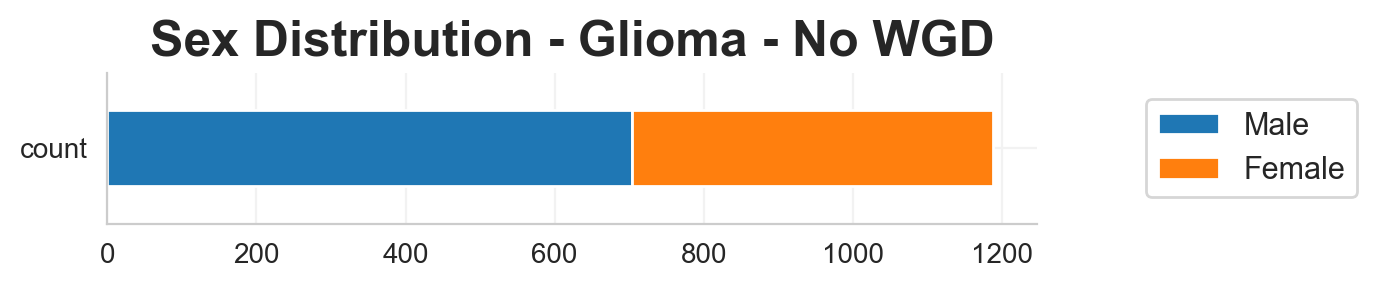

In [52]:
h = get_groupby(master_no_wgd_cancer,'Sex', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[['Male', 'Female']]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax)
ax.legend(['Male', 'Female'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Sex Distribution - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

### Survival Analysis

In [53]:
from lifelines import KaplanMeierFitter

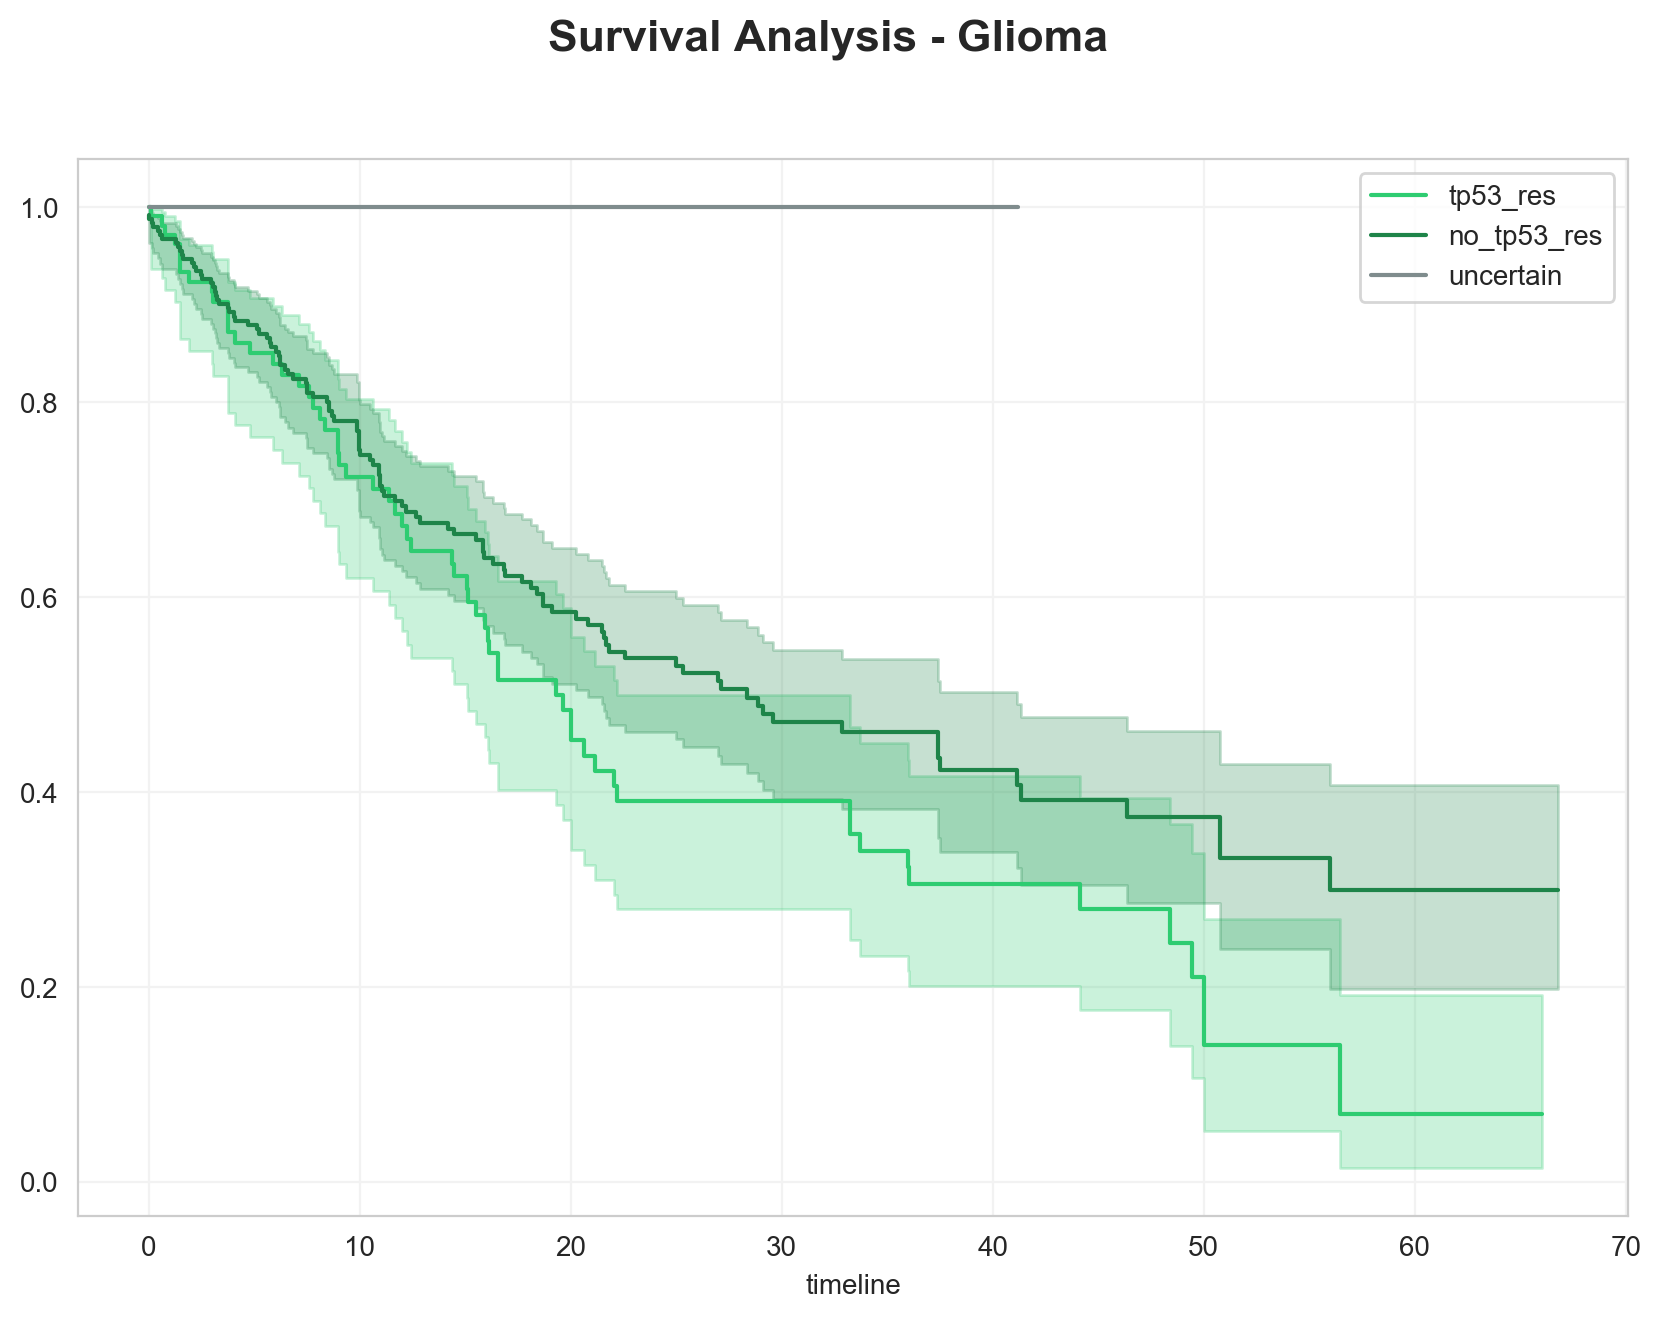

In [54]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(res_group_list, range(len(res_group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_res_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = res_palette_list[i], ax=ax)
plt.show()

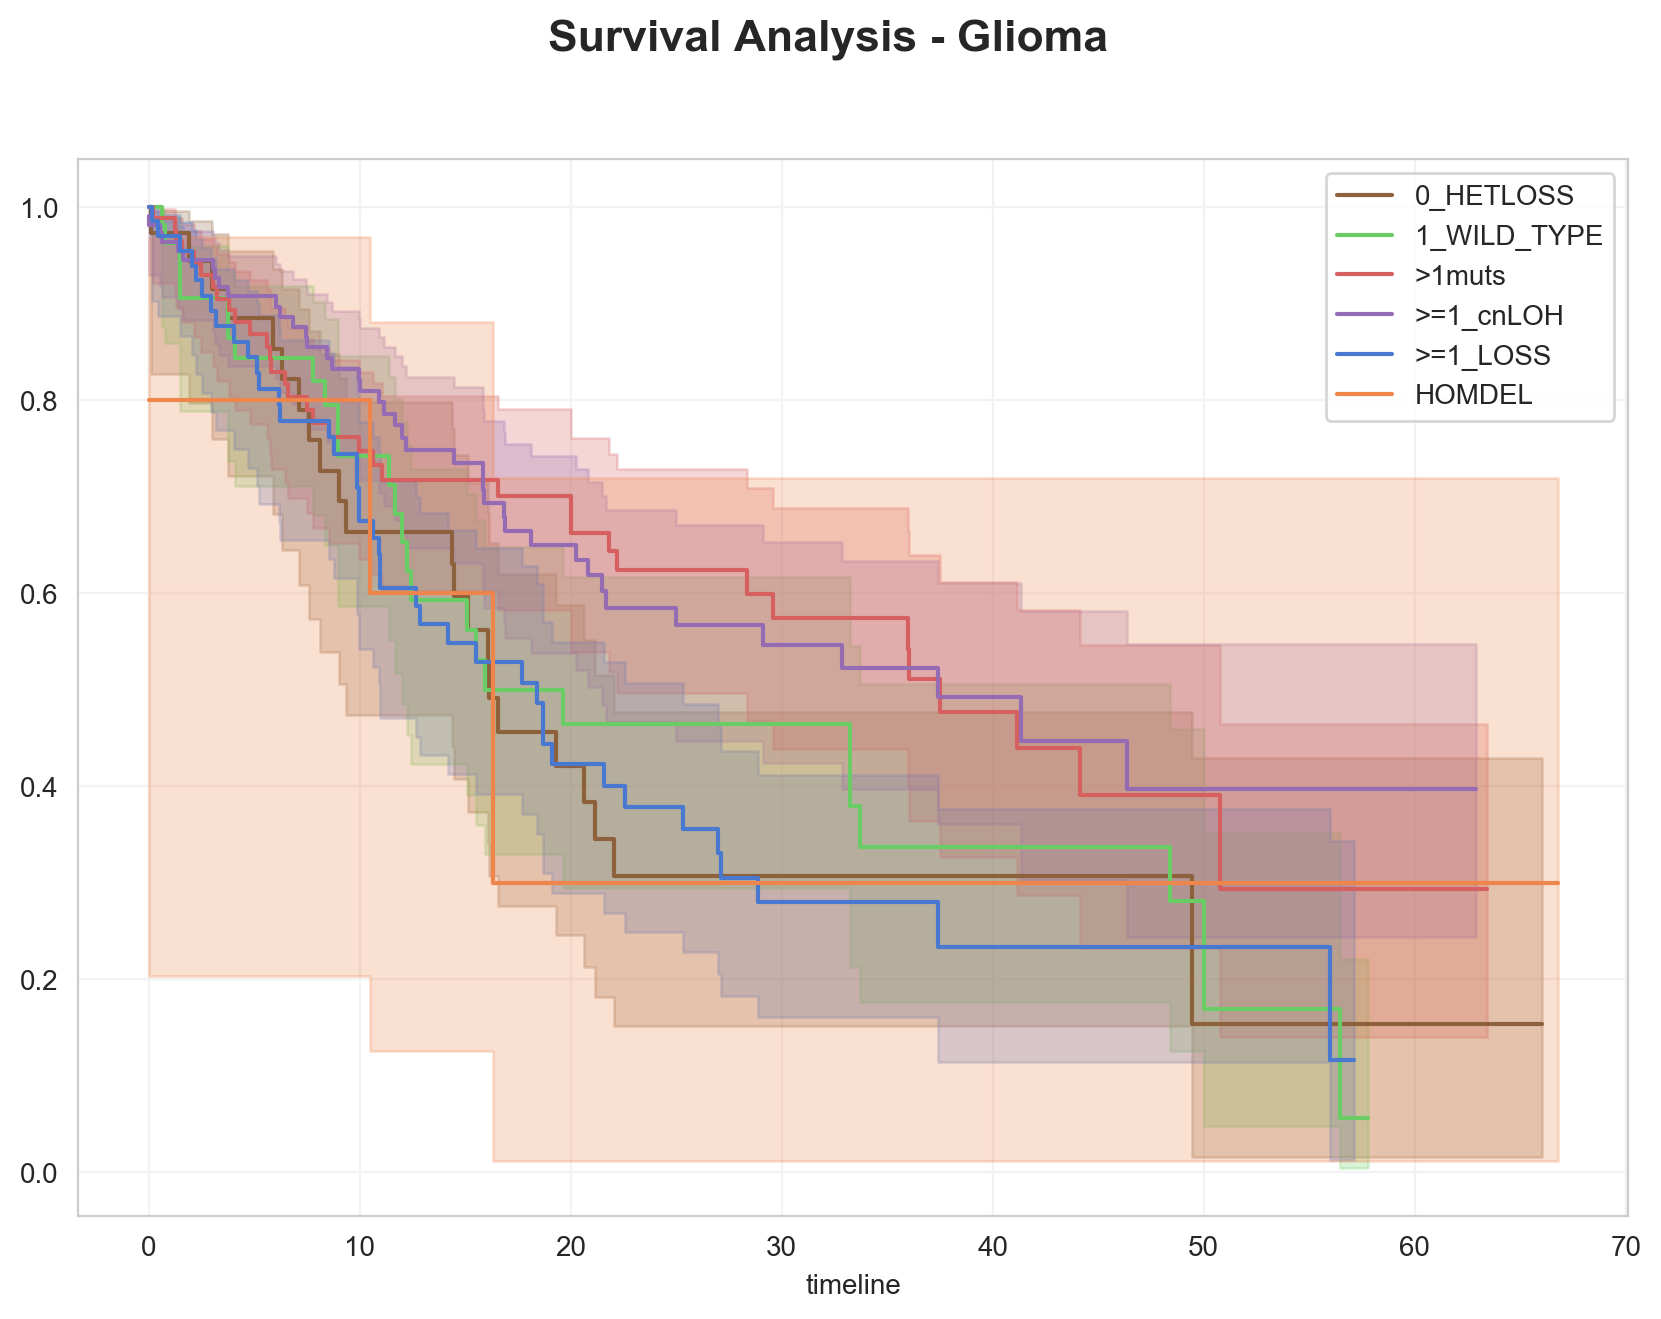

In [55]:

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(group_list, range(len(group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = palette_list[i], ax=ax)
plt.show()